In this section, we'll be focusing on several financial market case studies using Python.

In [1]:
import os

# So we don't see deprecated warnings... when you're coding it's usually good to leave these!
import warnings
warnings.filterwarnings('ignore')

# Disable logging messages, to make output tidier
# import logging, sys
# logging.disable(sys.maxsize)

%matplotlib inline
import math

import pandas as pd
import numpy as np

# For plotly
import plotly.offline as py_offline

import plotly.io as pio
pio.renderers.default = "notebook" # larger notebook files, but interactive plots
# pio.renderers.default = "svg"
# pio.renderers.default = "png" # smaller notebook files

from findatapy.market import Market, MarketDataGenerator, MarketDataRequest
from findatapy.timeseries import Calculations

from chartpy import Chart, Style

# note you might need to create this folder or change it!
raw_data_path = 'raw_data/'

# Either set API keys as an environment variable (preferred for security reasons) 
# or easier to just replace these below, with your own keys (if you aren't sharing your notebooks)
try:
    QUANDL_API_KEY = os.environ['QUANDL_API_KEY']
    FRED_API_KEY = os.environ['FRED_API_KEY']
    ALPHA_VANTAGE_API_KEY = os.environ['ALPHA_VANTAGE_API_KEY']
except:
    pass

## Understanding the behaviour of FX around major data events

### What are we looking at?

* US Employment Situation
    * This is generally released on the first Friday of every month. 
    * It constitutes the first bit of hard economic data for US
    * The most important statistics from the report are
        * Change in nonfarm payrolls
        * Unemployment rate
        * In the market the release will often just be referred to as "payrolls" or "NFP"

* Central bank decisions
    * Every few weeks central banks meet to make decisions around monetary policy
    * The market is not only interested in what they will do (eg. hike rates, keep on hold), but also the language they use in any public statement, which can give indications of future policy change.
    * Central banks can adjust their forecasts to give the market forward guidance
    * Central banks also communicate with the market through regular public speeches and appearances
    * We shall focus on the monetary policy meetings of the Federal Reserve and ECB

### Event study

An event study basically looks at the price action around specific event points. In our case, we'll be looking at EUR/USD tick data, which has been resampled into 1 minute chunks. Our events will consist of the US employment report, FOMC decisions and ECB decisions. 

We first download EUR/USD tick data from DukasCopy. This will likely take a very long time. To reduce the download time, you can choose a much small sample (eg. just 2018). We will cache this by writing to disk as Parquet files and also CSV. CSV is a plain text format, which is very easy to read. However, the files tend to be bigger (we have not applied compression too). Parquet is a commonly used binary data format. By default Pandas uses the snappy algorithm for compression of Parquet files. We have used gzip (mainly because it's easier to install - but you can use snappy if you want!). We have also stored the files partitioned by year. When dealing with time series data, it is a good idea to partition them into files by date. This is especially the case for tick data, where the file sizes can be massive.

Note, this will be in UTC timezone/GMT timezone. In general, with intraday data I would strongly recommend working in UTC/GMT timezone and having this as the way you store data. It causes problems in general using other timezones (in particular when there are daylight savings time changes).

In [2]:
# First we can do it by defining all the vendor fields, tickers etc. so we bypass the configuration file
md_request = MarketDataRequest(
    start_date='01 Jan 2007', finish_date='30 Jun 2019',
    fields=['bid', 'ask'], vendor_fields=['bid', 'ask'],
    freq='tick', data_source='dukascopy',
    tickers=['EURUSD'], vendor_tickers=['EURUSD'], category='fx')

market = Market(market_data_generator=MarketDataGenerator())

compression_type = 'gzip' # you can change this to 'snappy' if you want!

# Only download file if not on disk (slow to download),
# then write to disk as parquet
# Note: writing to CSV takes a long time, so we have commented it here!
if not(os.path.exists(raw_data_path + 'EURUSD.gzip')):
    df_tick = market.fetch_market(md_request)

    df_tick.to_parquet(raw_data_path + 'EURUSD.gzip', compression=compression_type)
    
    start_year = df_tick.index[0].year
    finish_year = df_tick.index[-1].year

    for i in range(start_year, finish_year + 1):
        df_year = df_tick[df_tick.index.year == i]
        df_year.to_parquet(raw_data_path + 'EURUSD_' + str(i) + '.gzip', 
                           compression=compression_type)
        # df_year.to_csv(raw_data_path + 'EURUSD_' + str(i) + '.csv')
else:
    # Edit the below line if you want to pick only one of the yearly Parquet files
    # If you load the whole amount might run out of memory!
    df_tick = pd.read_parquet(raw_data_path + 'EURUSD_2019.gzip')

We'll also create smaller parquet files, if they don't exist, which are split by year. Typically for tick data, it's generally good practice to split the files up into manageable chunks. You could also try splitting up files into month and years.

### Calculate mid price and bid/offer spread

Now that we have downloaded the EUR/USD tick data (or read a cached copy from disk), we can start to do some calculations on it. The first step is to calculate the mid price. We'll also calculate the spread between bid and ask prices so that it is in basis points (100 basis points is equivalent to 1%).

In [3]:
df_tick['mid'] = (df_tick['EURUSD.ask']+df_tick['EURUSD.bid'])/2.0
df_tick['spread_bp'] = 10000 * \
    (df_tick['EURUSD.ask']-df_tick['EURUSD.bid']) / df_tick['mid']

Let's take a quick look at the data. Generally speaking, it is always a good idea to look at the data (and also to plot it before playing with it!)

In [4]:
print(df_tick['mid'].tail(n=10))

Date
2019-06-28 20:59:18.051    1.137075
2019-06-28 20:59:24.399    1.137070
2019-06-28 20:59:26.633    1.137070
2019-06-28 20:59:30.393    1.137060
2019-06-28 20:59:37.222    1.137055
2019-06-28 20:59:37.852    1.137050
2019-06-28 20:59:47.271    1.137110
2019-06-28 20:59:51.136    1.137210
2019-06-28 20:59:53.030    1.137210
2019-06-28 20:59:56.344    1.137205
Name: mid, dtype: float64


We can resample the data so that it is hourly form, taking the last point of the hour. Let's drop all the NaNs (eg. over weekends)

In [5]:
df_hourly = df_tick.resample("1h").last().dropna()

We can now plot it, with Chartpy using a Matplotlib backend. If we try plotting very high frequency data, it is likely our plotter would run out of memory, so it is often worth downsampling the data first.

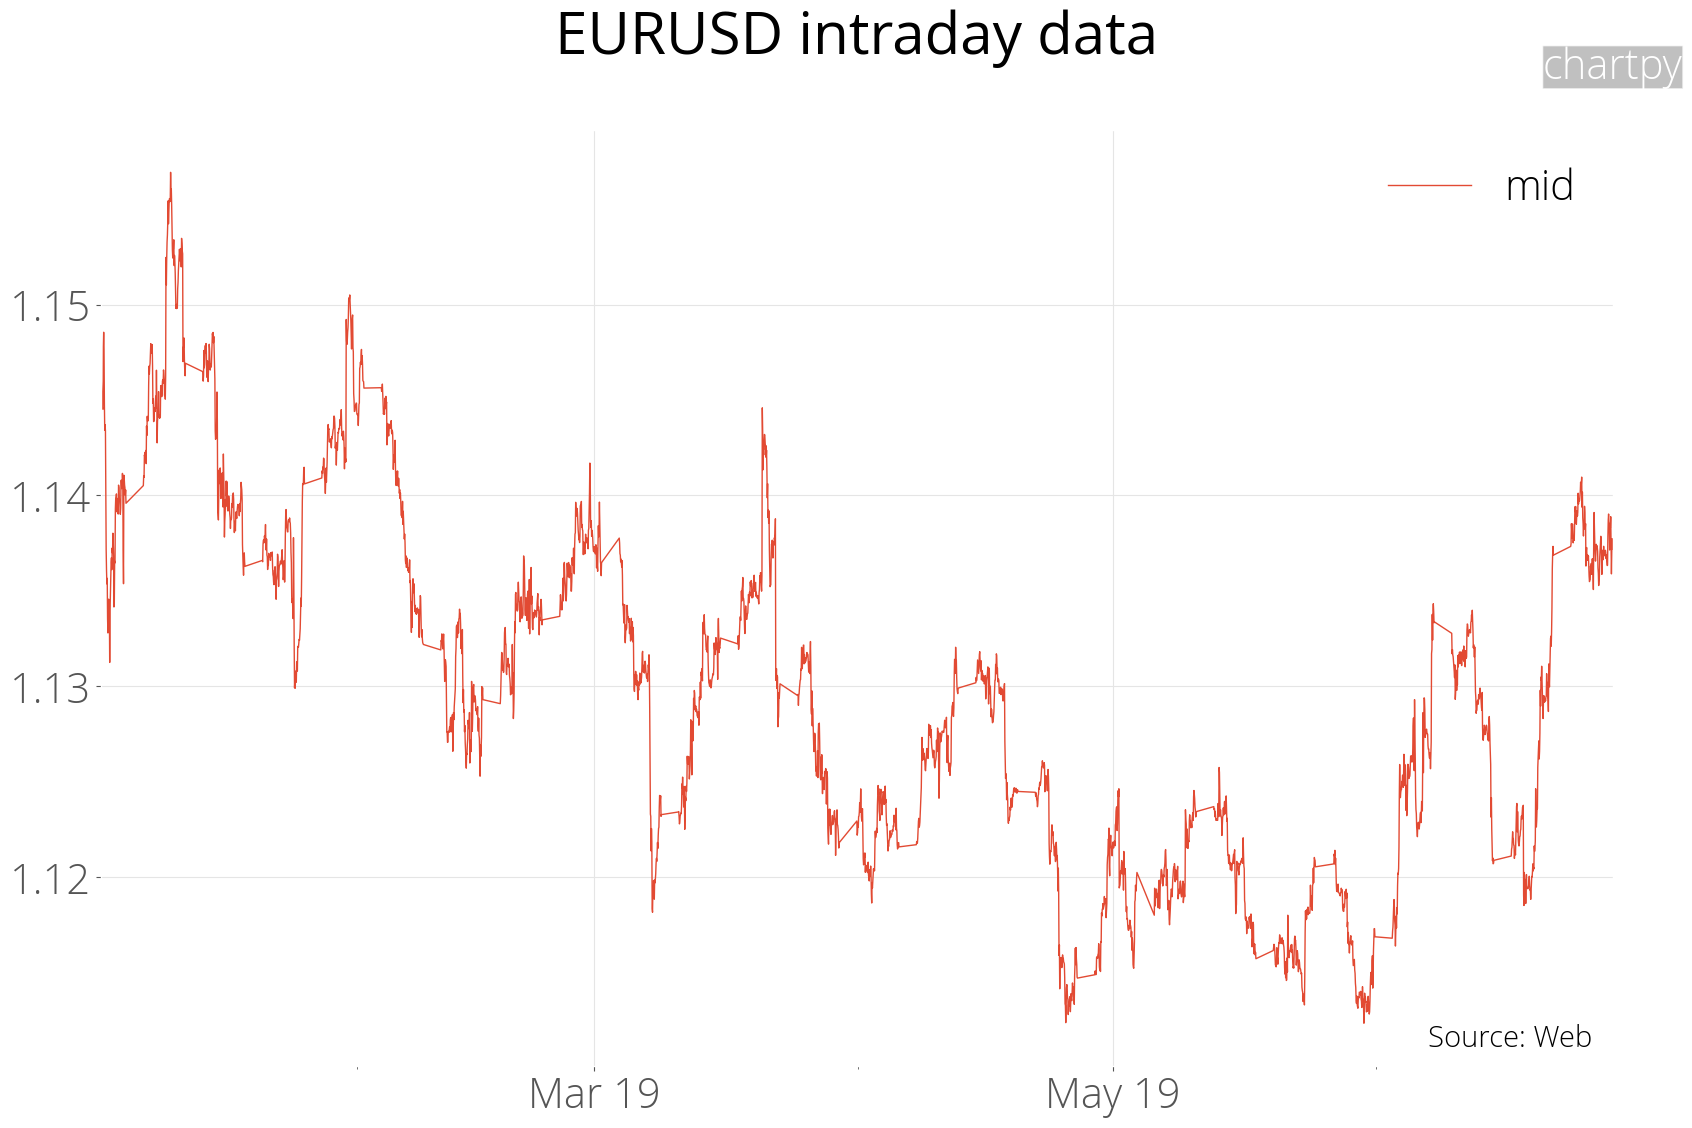

In [6]:
style = Style(title="EURUSD intraday data")

Chart(engine="matplotlib").plot(df_hourly['mid'], style=style)

Let's resample our tick data into 1 minute buckets, taking the mean rather than the last point.

In [7]:
df_minute = df_tick.resample("1min").mean().dropna()

Now we plot the the spread. There's pretty obvious seasonality as we might expect.

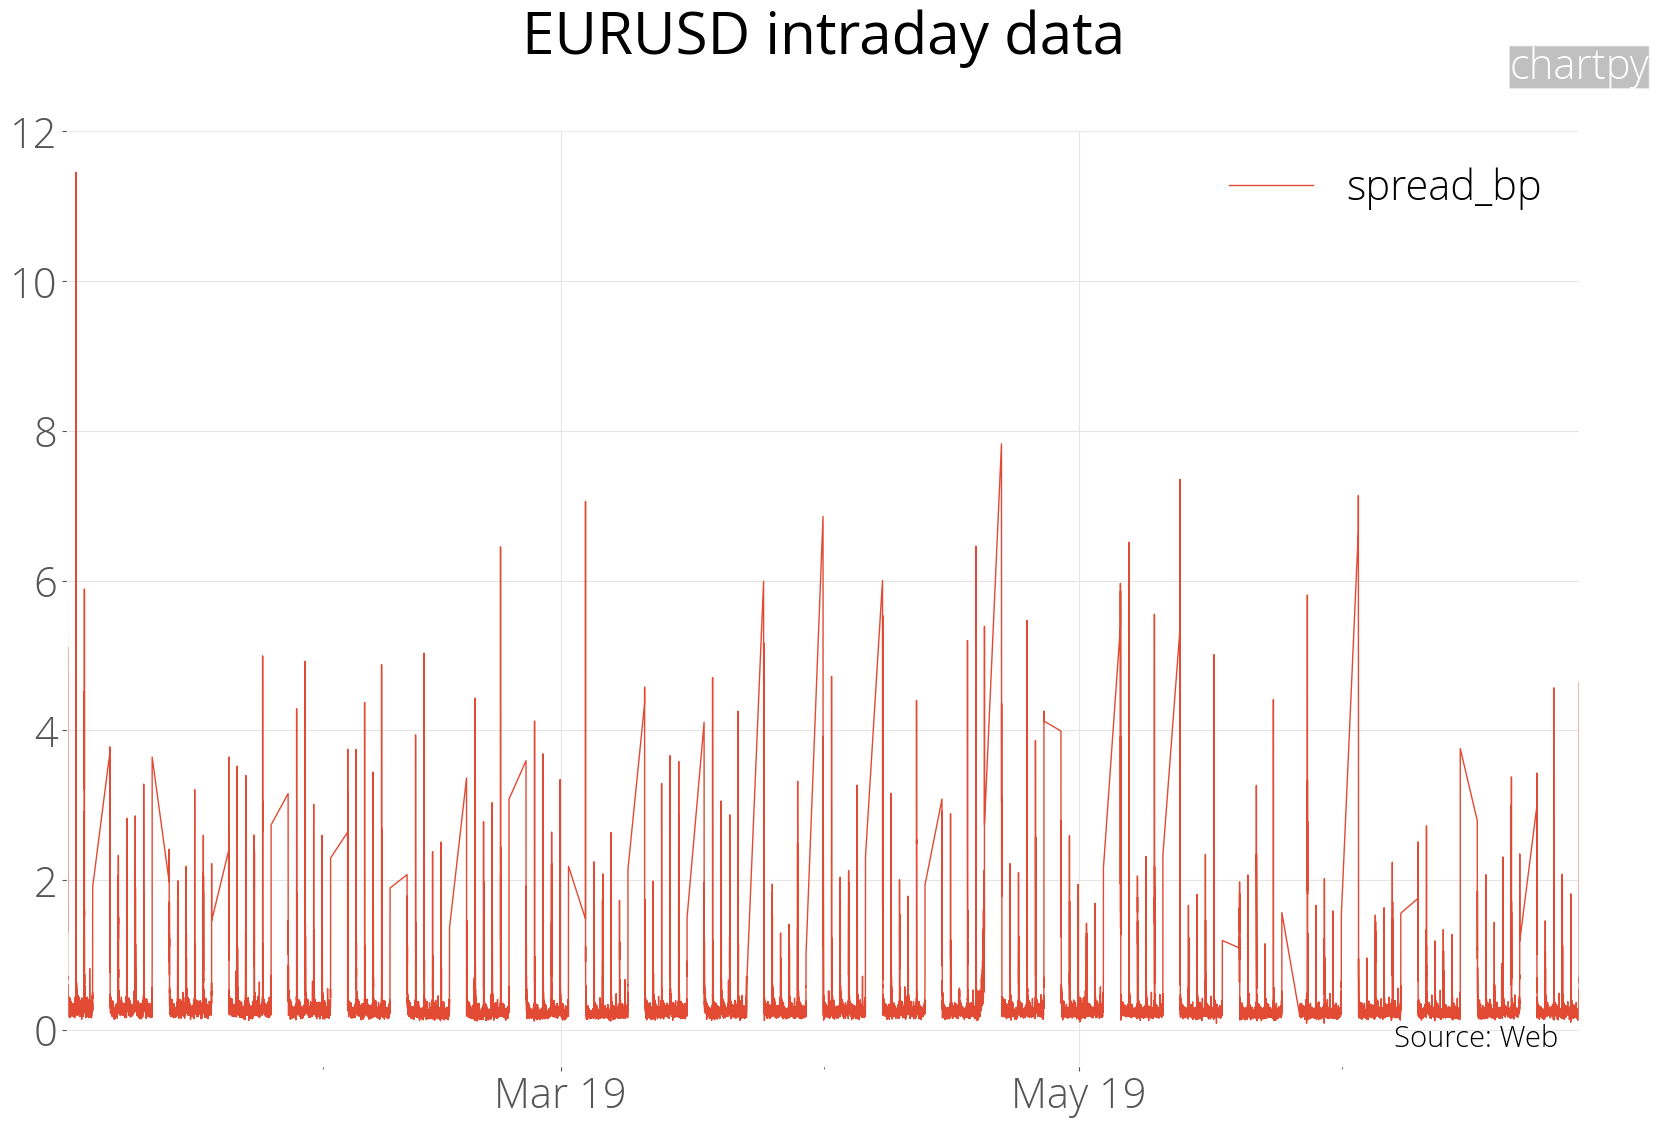

In [8]:
Chart(engine="matplotlib").plot(df_minute['spread_bp'], style=style)

We can also a distribution plot of the spread, using the Seaborn library. Most of the observations are concentrated around 0 basis points. We have a small number of outliers above 10 basis points.

<AxesSubplot:xlabel='spread_bp', ylabel='Density'>

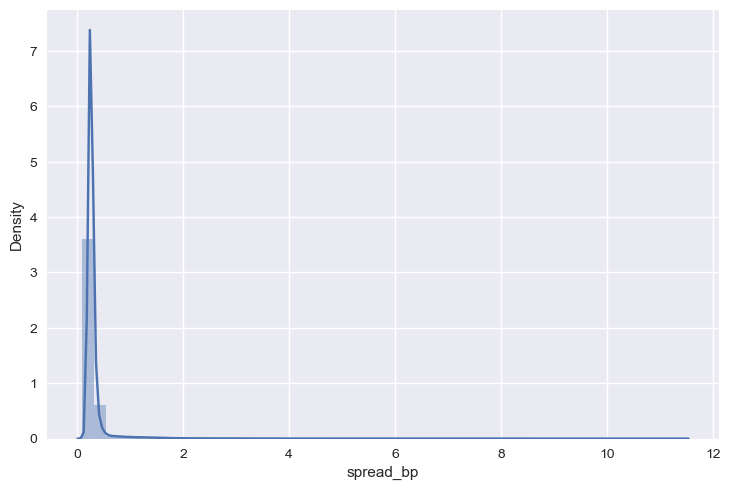

In [9]:
import seaborn as sns

import matplotlib.pyplot as plt

plt.style.use('seaborn') # changes the matplotlibplot style...

sns.distplot(df_minute['spread_bp'])

### Calculate volatility based on 1 minute buckets around NFP

The next step is to calculate volatility based on one minute buckets. We'll try a number of different volatility estimators, and see what the difference is between them. To begin with we need to calculate the open/high/low/close of every minute of data. Pandas can do this in one line!

In [10]:
df_ohlc = df_tick['mid'].resample("1min").ohlc().dropna()

Let's take a quick look at the open/high/low/close data.

In [11]:
print(df_ohlc.head(n=10))

                         open      high       low     close
Date                                                       
2019-01-01 22:02:00  1.146400  1.146415  1.146400  1.146410
2019-01-01 22:03:00  1.146410  1.146490  1.146410  1.146425
2019-01-01 22:04:00  1.146455  1.146455  1.146355  1.146355
2019-01-01 22:05:00  1.146355  1.146540  1.146355  1.146540
2019-01-01 22:06:00  1.146530  1.146740  1.146220  1.146735
2019-01-01 22:07:00  1.146735  1.146770  1.146405  1.146415
2019-01-01 22:08:00  1.146420  1.146420  1.146400  1.146420
2019-01-01 22:09:00  1.146405  1.146460  1.146400  1.146405
2019-01-01 22:10:00  1.146410  1.146410  1.146400  1.146400
2019-01-01 22:11:00  1.146405  1.146455  1.146380  1.146390


We'll be adapting the code from https://github.com/jasonstrimpel/volatility-trading/tree/master/volatility/models which is based on the models discussed in Volatility Trading by Euan Sinclair (see https://www.amazon.com/gp/product/0470181990/). Exploring the predictability of range-based volatility estimators using RNNs by Gabor Petnehazi and Jozsef Gall (see https://arxiv.org/pdf/1803.07152.pdf) also discusses the various differences between the various volatility estimators.

#### Close-to-close volatility estimators

Let's first do the function for the simplest measure, ie. standard deviation. We are assuming that each window is 5 minutes long. The trading period is 252*1440 because there are around 252 trading days in a year and 1440 minutes per day.

In [12]:
def vol_std_dev(df, window=5, trading_periods=252*1440):
    log_return = (df['close'] / df['close'].shift(1)).apply(np.log)

    return log_return.rolling(
        window=window,
        center=False
    ).std() * math.sqrt(trading_periods)

We'll now define the Hodges-Tompkins volatilty estimator. Note, that it is very similar, multiplying our standard deviations estimator by an adjustment factor which depends on the window size and the number of points.

In [13]:
def vol_hodges_tompkins(df, window=5, trading_periods=252*1440):
    
    log_return = (df['close'] / df['close'].shift(1)).apply(np.log)

    vol = log_return.rolling(
        window=window,
        center=False
    ).std() * math.sqrt(trading_periods)

    h = window
    n = (log_return.count() - h) + 1

    adj_factor = 1.0 / (1.0 - (h / n) + ((h**2 - 1) / (3 * n**2)))

    return vol * adj_factor

#### Incorporating open/high/low information into volatility estimators

So far we have only used volatility estimators which look at the data from close to close. However, what about what happens during the period? Is there additional information content in that. What about if we incorporate the open/high/low data, as well as the close to capture this as well?

In [14]:
def vol_parkinson(df, window=5, trading_periods=252*1440):

    rs = (1.0 / (4.0 * math.log(2.0))) * ((df['high'] / df['low']).apply(np.log))**2.0

    def f(v):
        return (trading_periods * v.mean())**0.5
    
    return rs.rolling(
        window=window,
        center=False
    ).apply(func=f)

We now define Garman-Klass volatility estimator, which also incorporates the open/close data.

In [15]:
def vol_garman_klass(df, window=5, trading_periods=252*1440):
    log_hl = (df['high'] / df['low']).apply(np.log)
    log_co = (df['close'] / df['open']).apply(np.log)

    rs = 0.5 * log_hl**2 - (2*math.log(2)-1) * log_co**2

    def f(v):
        return (trading_periods * v.mean())**0.5

    return rs.rolling(window=window, center=False).apply(func=f)

Both Parkinson and Garman-Klass assume the asset prices follow a continuous Brownian motion with no drift (ie. is not trending in a specific direction).

Let's define Rogers-Satchell volatility estimator, which allows for drift in the underlying.

In [16]:
def vol_rogers_satchell(df, window=5, trading_periods=252*1440):
    
    log_ho = (df['high'] / df['open']).apply(np.log)
    log_lo = (df['low'] / df['open']).apply(np.log)
    log_co = (df['close'] / df['open']).apply(np.log)
    
    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    def f(v):
        return (trading_periods * v.mean())**0.5
    
    return rs.rolling(
        window=window,
        center=False
    ).apply(func=f)

Finally we show the Yang-Zhang volatility estimator, which allows for drifts and also deals with opening jumps consistently (ie. when the market has been closed for a period, during the weekend or overnight). Some markets like bitcoin trade continuously, and hence are not subject to these opening jumps. Developed FX markets have jumps over the weekend, when the market is closed, but not overnight, when they are traded continuously. EMFX tends to exhibit more of these overnight jumps (some markets such as BRL will be closed overnight), but depends on the currency pair.

In [17]:
def vol_yang_zhang(df, window=5, trading_periods=252*1440):

    log_ho = (df['high'] / df['open']).apply(np.log)
    log_lo = (df['low'] / df['open']).apply(np.log)
    log_co = (df['close'] / df['open']).apply(np.log)
    
    log_oc = (df['open'] / df['close'].shift(1)).apply(np.log)
    log_oc_sq = log_oc**2
    
    log_cc = (df['close'] / df['close'].shift(1)).apply(np.log)
    log_cc_sq = log_cc**2
    
    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)
    
    close_vol = log_cc_sq.rolling(
        window=window,
        center=False
    ).sum() * (1.0 / (window - 1.0))
    open_vol = log_oc_sq.rolling(
        window=window,
        center=False
    ).sum() * (1.0 / (window - 1.0))
    window_rs = rs.rolling(
        window=window,
        center=False
    ).sum() * (1.0 / (window - 1.0))

    k = 0.34 / (1 + (window + 1) / (window - 1))
    return (open_vol + k * close_vol + (1 - k) * window_rs).apply(np.sqrt) * math.sqrt(trading_periods)

We'll add a function for converting a Series to a DataFrame and labelling it and another for selecting a specific date from the DataFrame.

In [18]:
def convert_dataframe(df, col):
    df = pd.DataFrame(df)
    df.columns = [col]
    
    return df

def grab_days_data(df, date):
    from datetime import timedelta
    
    end_date = pd.Timestamp(date) + timedelta(days=1)
    return df[(df.index > date) & (df.index < end_date)]

#### Plotting volatility on a NFP day (US change in nonfarm payrolls)

Let's grab the data for the first payrolls date of 2019, in January 2019. This would relate to the period of December 2018.

In [19]:
df_snippet_ohlc = grab_days_data(df_ohlc, '04 Jan 2019')

Let's calculate some of the volatility estimators over this payrolls date. We notice an obvious jump in volatility at 13:30 UTC which corresponds to the time of NFP. There are also jumps in volatility at 16:00 UTC. The WMR FX fixing is at 16:00 LDN.

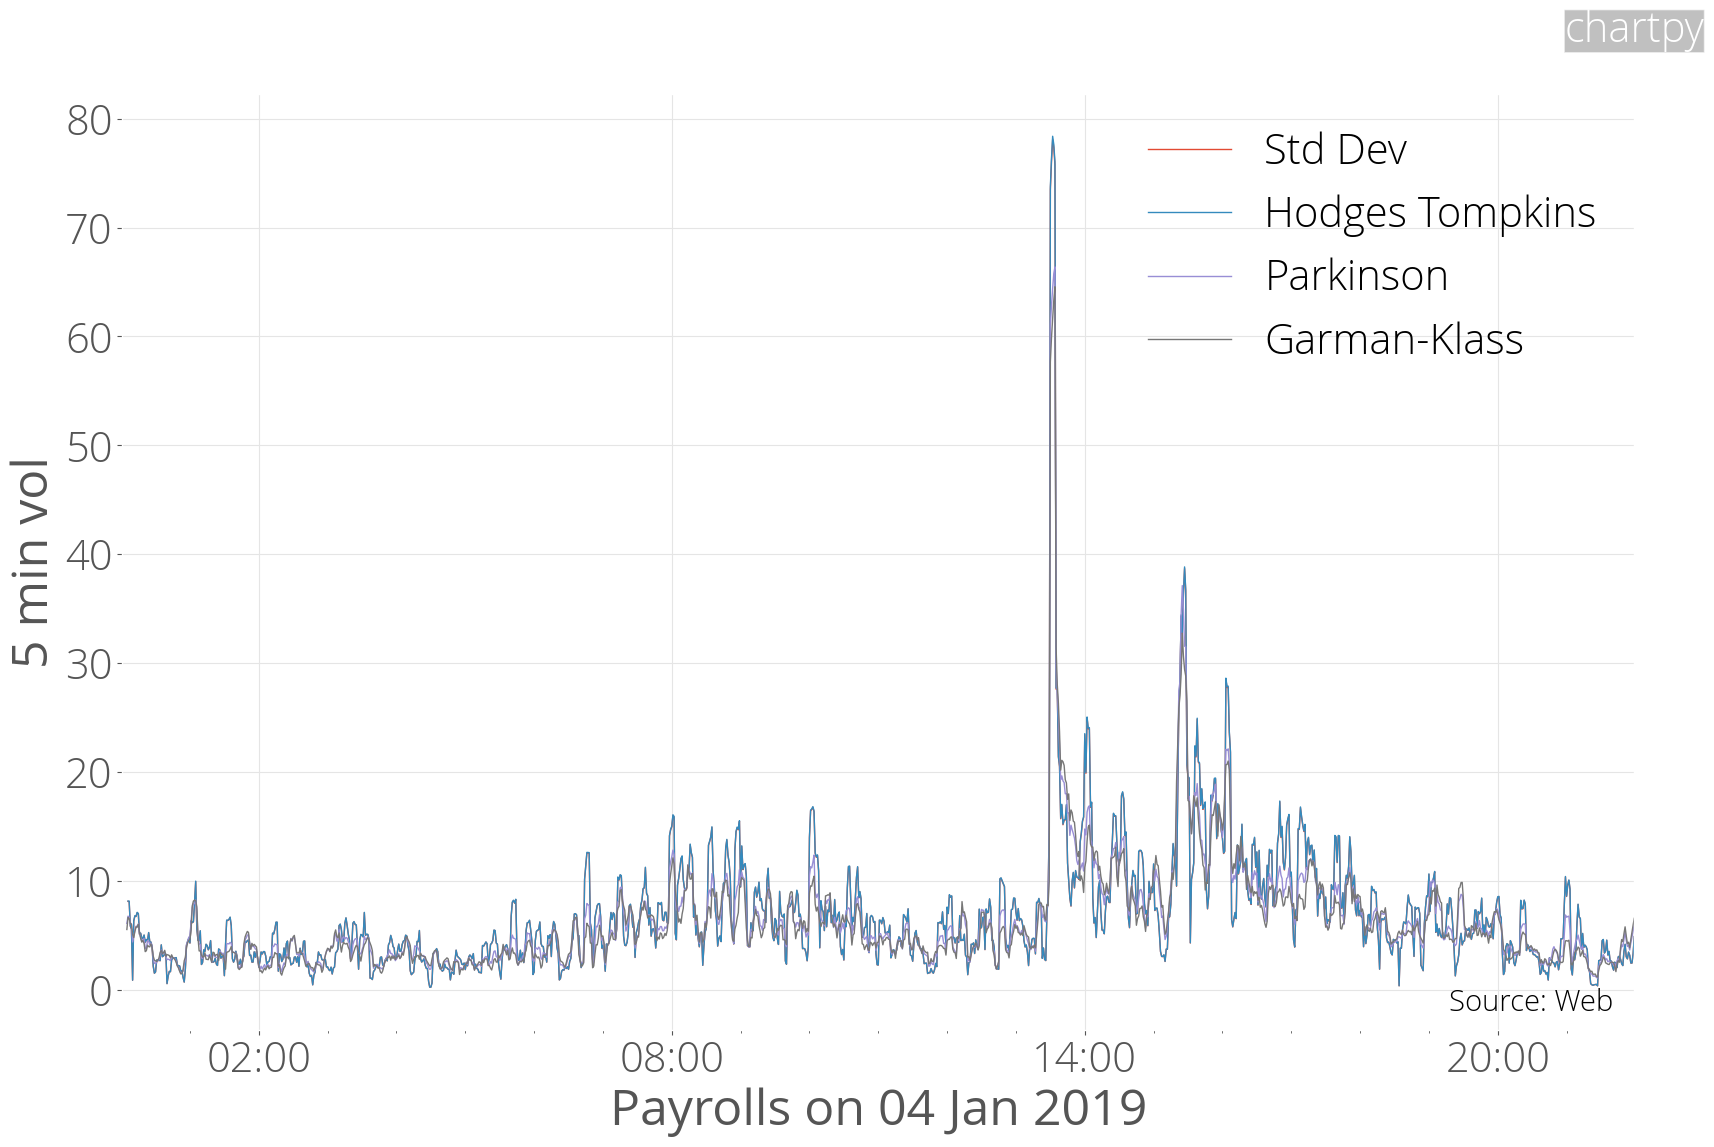

In [20]:
style = Style(y_title='5 min vol', x_title='Payrolls on 04 Jan 2019', plotly_plot_mode='offline_jupyter')

df_vol_std_dev = convert_dataframe(vol_std_dev(df_snippet_ohlc), 'Std Dev')
df_vol_hodges_tompkins = convert_dataframe(vol_hodges_tompkins(df_snippet_ohlc), 'Hodges Tompkins')
df_vol_parkinson = convert_dataframe(vol_parkinson(df_snippet_ohlc), 'Parkinson')
df_vol_garman_klass = convert_dataframe(vol_garman_klass(df_snippet_ohlc), 'Garman-Klass')

df_vol_plot = pd.concat([df_vol_std_dev, df_vol_hodges_tompkins, \
                         df_vol_parkinson, df_vol_garman_klass], axis=1) * 100
Chart(engine='matplotlib').plot(df_vol_plot, style=style);

Note, that Hodges-Tompkins ends up being very close to our standard deviation.

In [21]:
print(df_vol_std_dev.head(10))
print(df_vol_hodges_tompkins.head(10))

                      Std Dev
Date                         
2019-01-04 00:01:00       NaN
2019-01-04 00:02:00       NaN
2019-01-04 00:03:00       NaN
2019-01-04 00:04:00       NaN
2019-01-04 00:05:00       NaN
2019-01-04 00:06:00  0.081022
2019-01-04 00:07:00  0.080962
2019-01-04 00:08:00  0.058334
2019-01-04 00:09:00  0.055540
2019-01-04 00:10:00  0.008592
                     Hodges Tompkins
Date                                
2019-01-04 00:01:00              NaN
2019-01-04 00:02:00              NaN
2019-01-04 00:03:00              NaN
2019-01-04 00:04:00              NaN
2019-01-04 00:05:00              NaN
2019-01-04 00:06:00         0.081332
2019-01-04 00:07:00         0.081271
2019-01-04 00:08:00         0.058557
2019-01-04 00:09:00         0.055752
2019-01-04 00:10:00         0.008625


Now let's do the others...

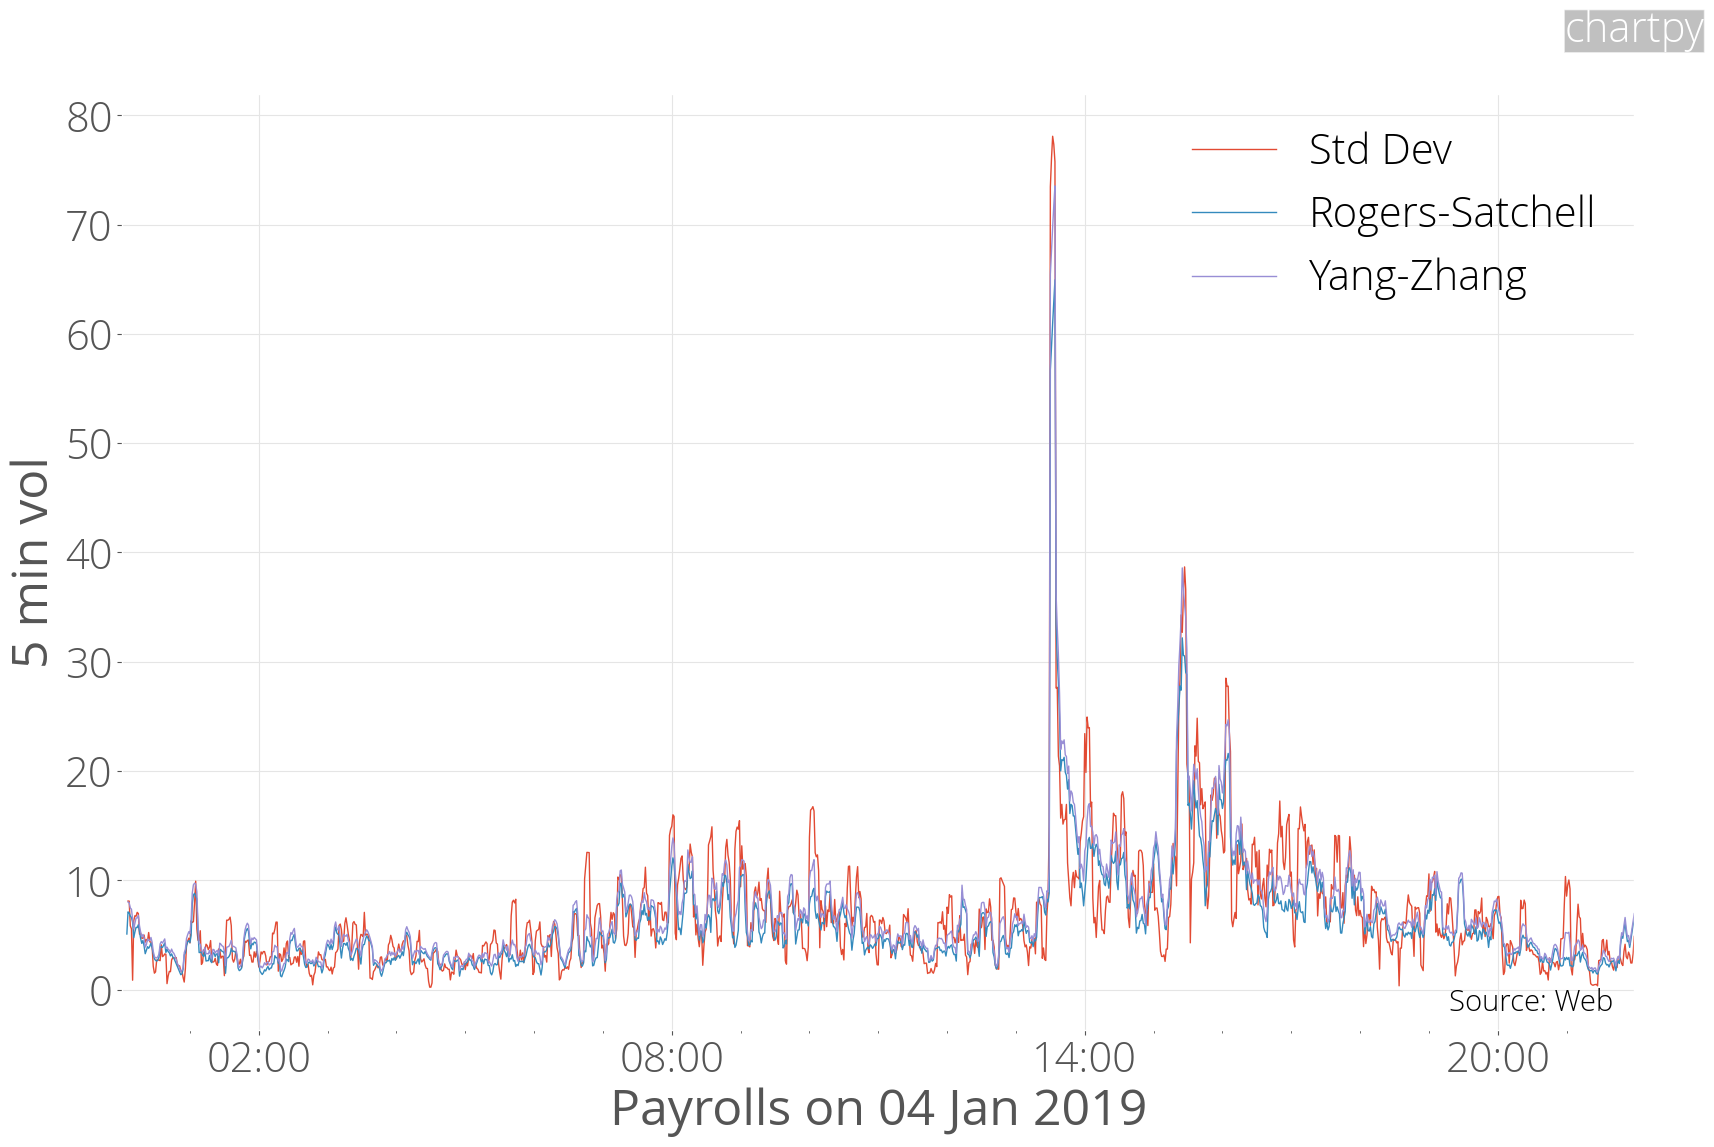

In [22]:
df_vol_std_dev = convert_dataframe(vol_std_dev(df_snippet_ohlc), 'Std Dev')
df_vol_rogers_satchell = convert_dataframe(vol_rogers_satchell(df_snippet_ohlc), 'Rogers-Satchell')
df_vol_yang_zhang = convert_dataframe(vol_yang_zhang(df_snippet_ohlc), 'Yang-Zhang')

df_vol_plot_2 = pd.concat([df_vol_std_dev, df_vol_rogers_satchell, \
                         df_vol_yang_zhang], axis=1) * 100

Chart(engine='matplotlib').plot(df_vol_plot_2, style=style)

### Price action around NFP

We looked at the volatility around a single NFP date/times. Here, we'll look at the moves in EUR/USD spot around a number of different NFP dates. The first step is to resample the data into 1 minute data, and get the opening price of each 1 minute bar.

In [23]:
df_minute = pd.DataFrame(df_tick['mid'].resample("1min").first()).dropna()

We now need to get all the NFP times (in UTC format). We'll read these from disk. We can find these on the Bureau of Labor Statistics eg. https://www.bls.gov/schedule/2018/home.htm for all their 2018 releases.

In [24]:
url_nfp = "https://raw.githubusercontent.com/cuemacro/teaching/master/pythoncourse/data/nfp_times.csv"
# url_nfp = raw_data_path + "/nfp_times.csv"

df_nfp_times = pd.read_csv(url_nfp, index_col=0)
df_nfp_times.index = pd.to_datetime(df_nfp_times.index)

We can now use the EventStudy class from finmarketpy to conduct the event study. We just need to give it returns of the asset we want to look at and all the event date/times, which in our case are the NFP data releases.

In [25]:
def calculate_event(df_minute, df_event_times, cumsum=True):

    from finmarketpy.economics import EventStudy

    es = EventStudy()
    calc = Calculations()
    
    if cumsum:
        df_minute = calc.calculate_returns(df_minute)

    # Work out cumulative asset price moves moves over the event
    df_event = es.get_intraday_moves_over_custom_event(df_minute, df_event_times, cumsum=cumsum)

    # Create an average move
    df_event['Avg'] = df_event.mean(axis=1)
    
    return df_event

We can now conduct the event study.

In [26]:
df_nfp_event = calculate_event(df_minute, df_nfp_times)

Let's print the event study time series. It basically shows us the cumulative percentage move in spot in the run up to NFP and in the minutes after it, where zero percentage displacement occurs at time zero (ie. the precise time of the data release).

In [27]:
print(df_nfp_event.head(n=5))

NFP.date-time  2019-01-04 13:30:00  2019-02-01 13:30:00  2019-03-08 13:30:00  \
-5                       -0.000097            -0.000013            -0.000058   
-4                       -0.000246             0.000004             0.000085   
-3                       -0.000311             0.000174             0.000374   
-2                       -0.000149             0.000126             0.000112   
-1                       -0.000026             0.000170            -0.000009   

NFP.date-time  2019-04-05 12:30:00  2019-05-03 12:30:00  2019-06-07 12:30:00  \
-5                       -0.000151             0.000090            -0.000004   
-4                       -0.000196             0.000117             0.000084   
-3                       -0.000329             0.000166             0.000115   
-2                       -0.000374             0.000247            -0.000133   
-1                       -0.000414             0.000143            -0.000439   

NFP.date-time       Avg  
-5          

Lastly, let's plot the event study. We'll begin by creating the Style object, which allows us to change the formatting of the chart.

In [28]:
def plot_event(df_event, title, factor=100):

    # Plotting spot over economic data event
    style = Style(title=title)

    # Plot in shades of blue (so earlier releases are lighter, later releases are darker)
    style.color = 'Blues';
    style.color_2 = []
    style.y_axis_2_series = []
    style.display_legend = False

    # Last release will be in red, average move in orange
    style.color_2_series = [df_event.columns[-2], df_event.columns[-1]]
    style.color_2 = ['red', 'orange']  # red, pink
    style.linewidth_2 = 2
    style.linewidth_2_series = style.color_2_series

    Chart(engine='matplotlib').plot(df_event * factor, style=style)

Let's call the plot_event method to plot recent NFP price action.

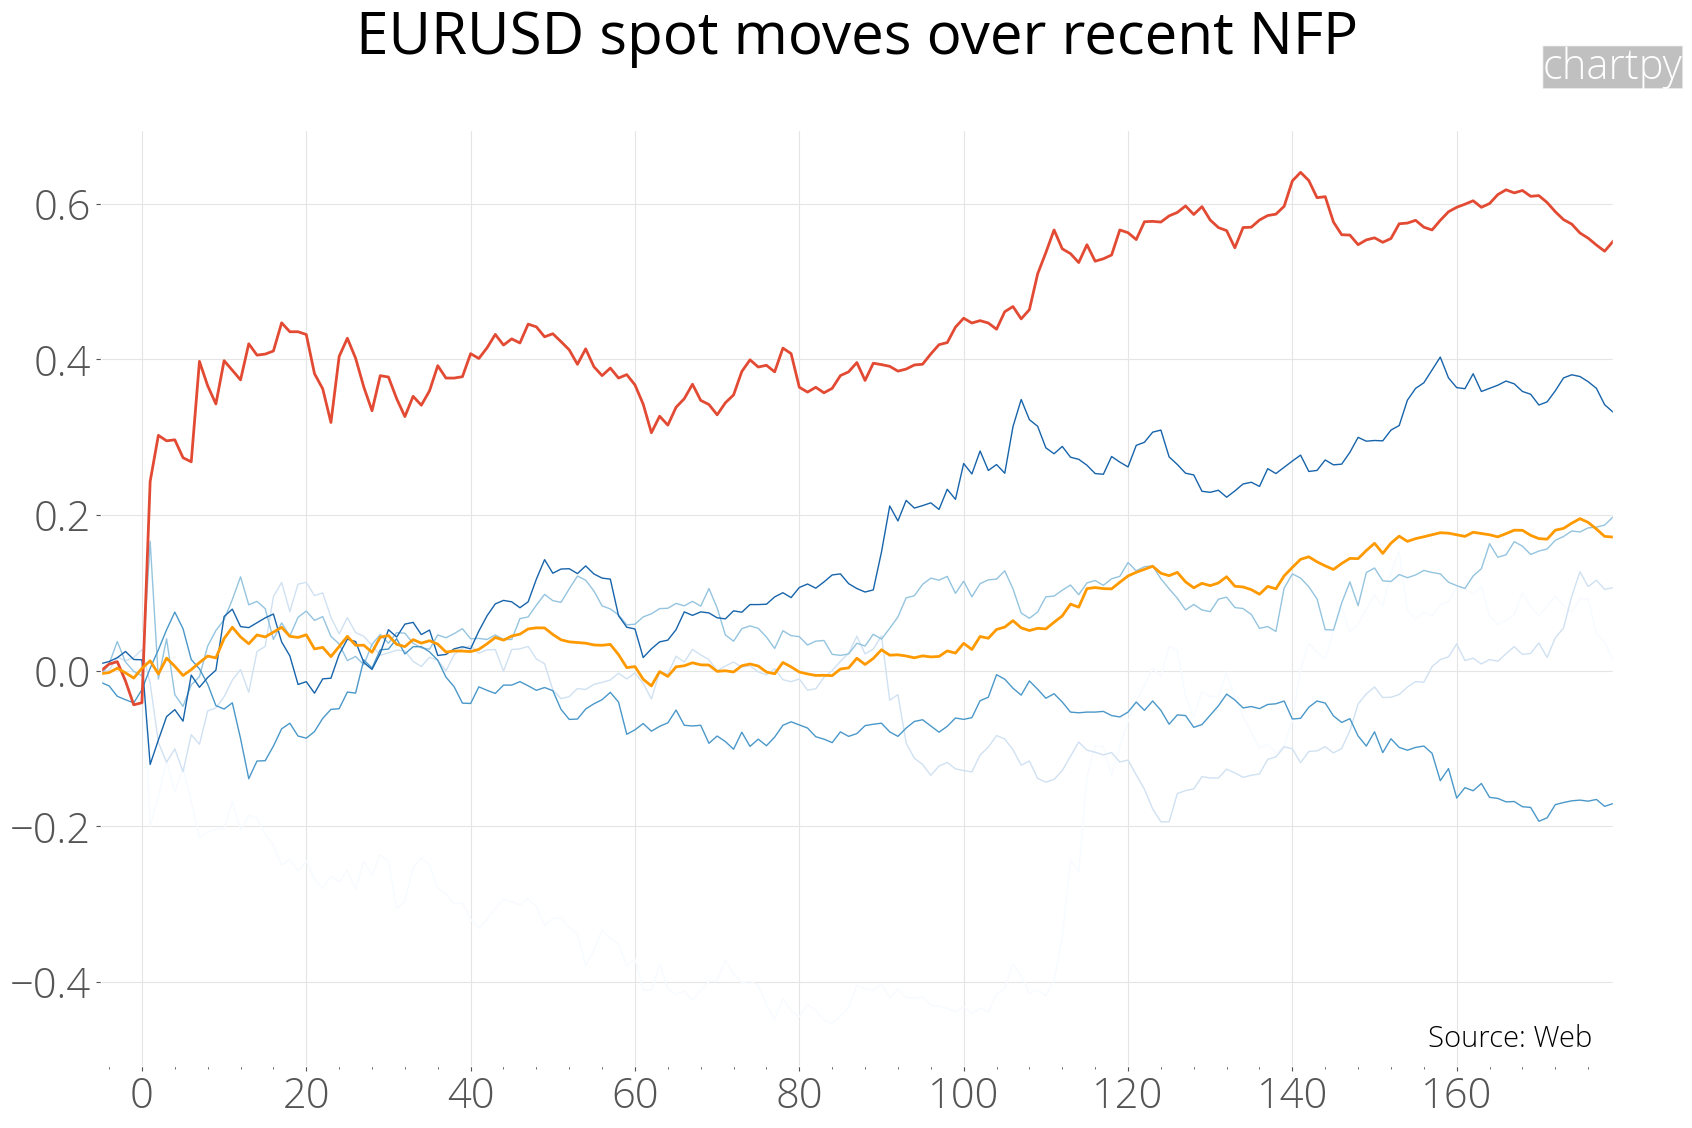

In [29]:
plot_event(df_nfp_event, 'EURUSD spot moves over recent NFP')

What about looking at bid/ask spreads around NFP? How do they behave? We note that spreads around the time of the release widen considerably. However, the market returns to normal relatively quickly.

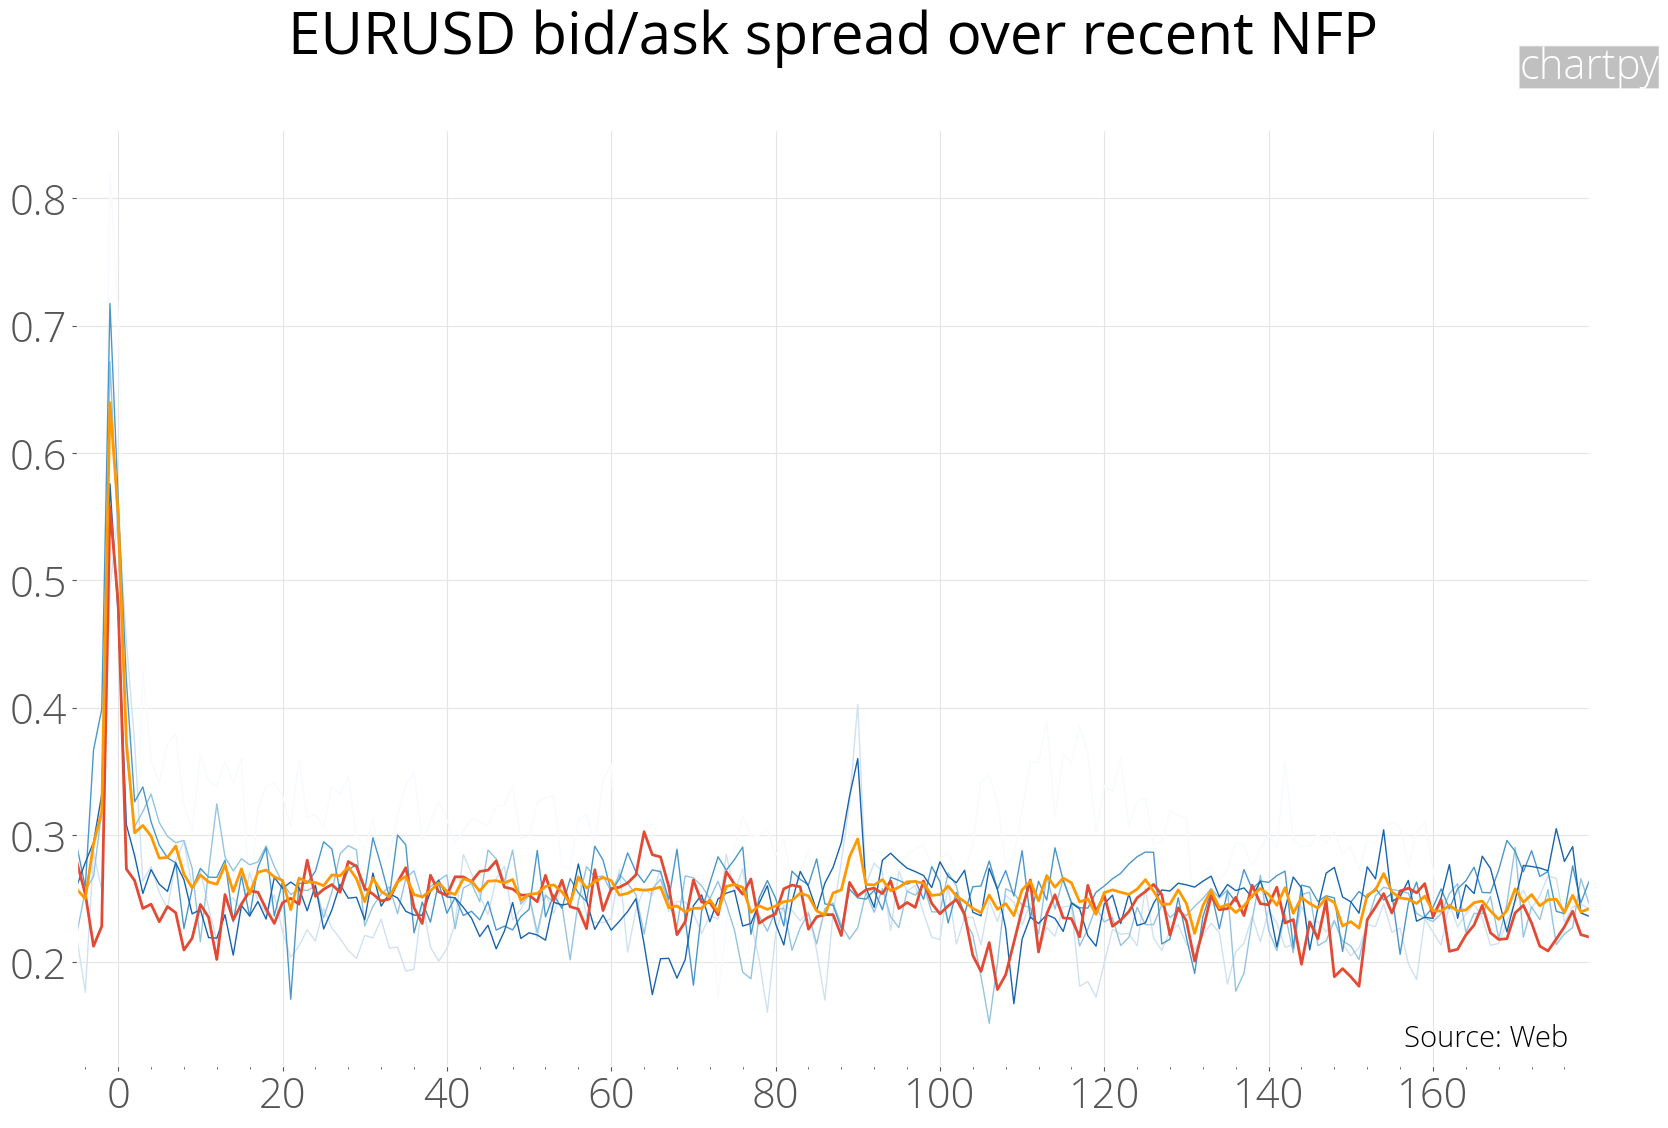

In [30]:
df_minute_spread_bp = pd.DataFrame(df_tick['spread_bp'].resample("1min").mean()).dropna()
df_nfp_event_spread = calculate_event(df_minute_spread_bp, df_nfp_times, cumsum=False)
plot_event(df_nfp_event_spread, 'EURUSD bid/ask spread over recent NFP', factor=1)

### Price action around FOMC

We can repeat the exercise for FOMC meetings, to see how EUR/USD reacted around them.

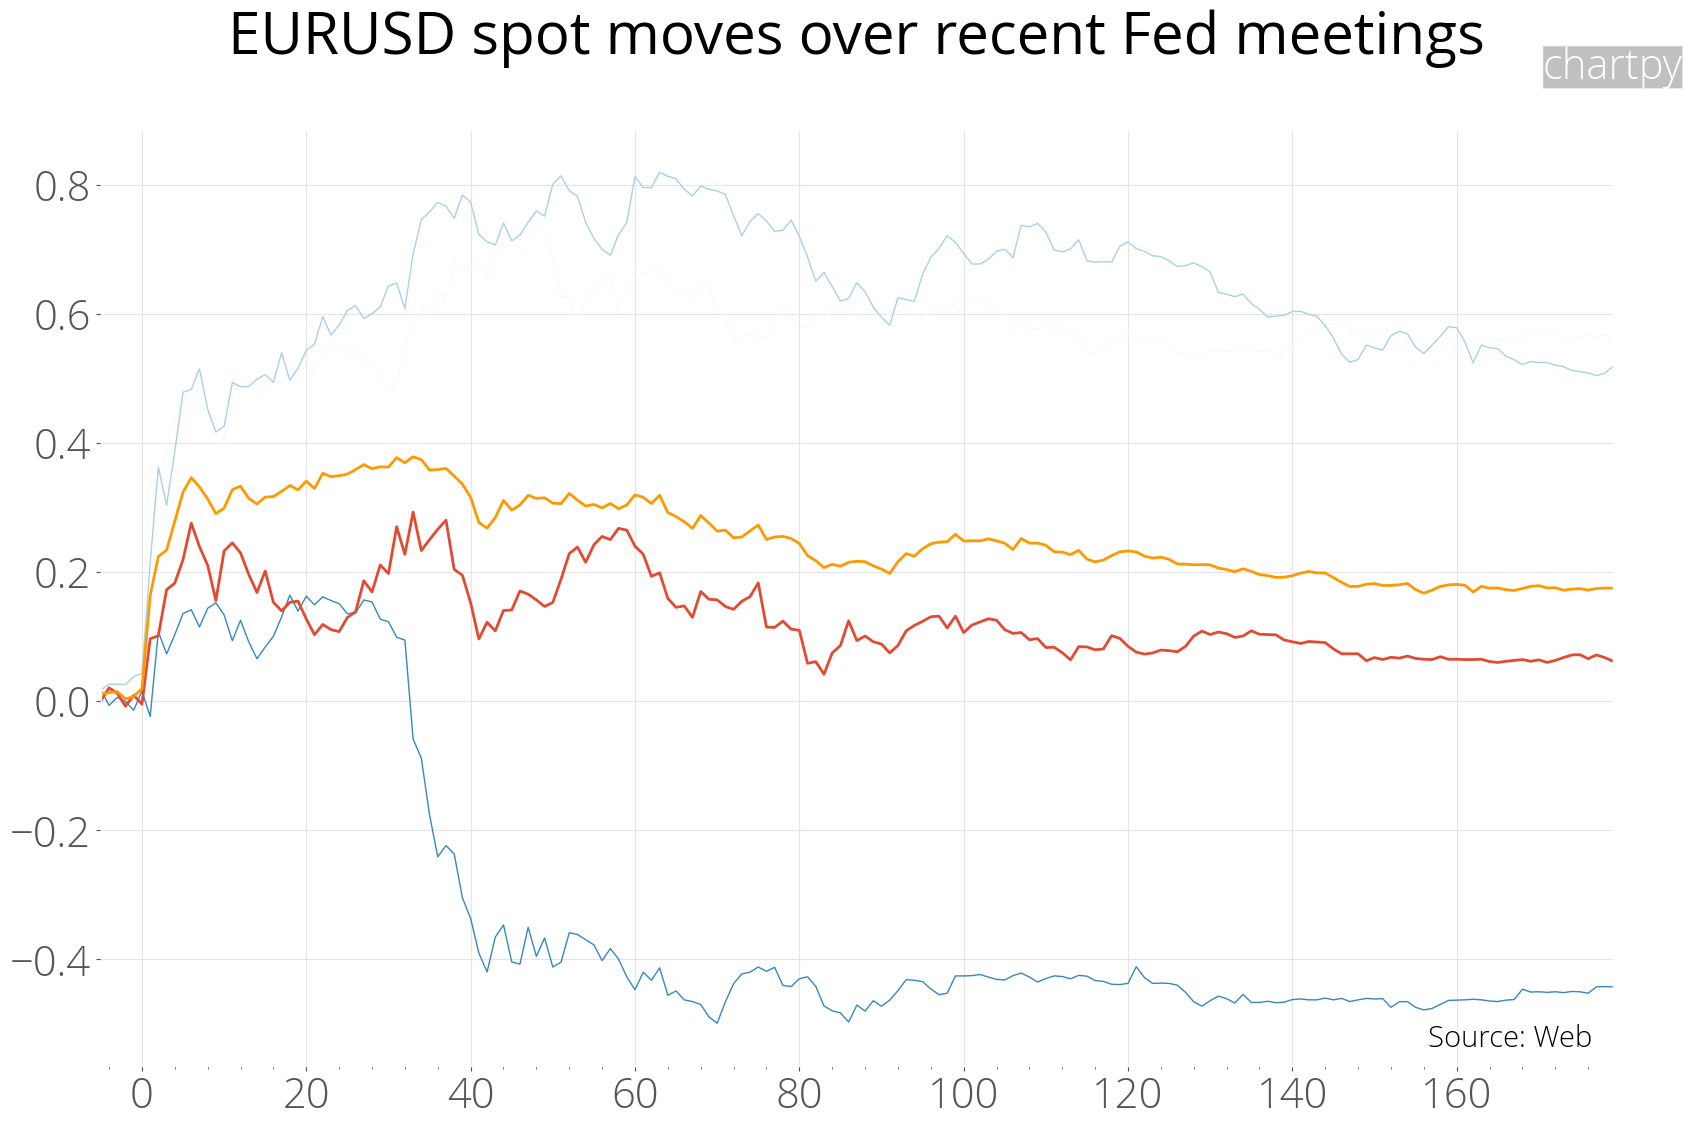

In [31]:
# Note: can read the Fed times directly from my GitHub area if you don't 
# want to manually collect the times from the Fed website!
url_fed = "https://raw.githubusercontent.com/cuemacro/teaching/master/pythoncourse/data/fed_times.csv"
# url_fed = raw_data_path + "/fed_times.csv"

df_fed_times = pd.read_csv(url_fed, index_col=0)
df_fed_times.index = pd.to_datetime(df_fed_times.index)

df_fed_event = calculate_event(df_minute, df_fed_times)
plot_event(df_fed_event, 'EURUSD spot moves over recent Fed meetings')

### What are data surprises?

Before an economic data release, the market has expectations of what it will be. One way to represent these expectations, is to look at the various consensus surveys conducted by data firms, of sell side economists. This can be a reasonable proxy (although not perfect) of what the market expects. We can also use a moving average of recent economic releases as another proxy for expectations, in particular where consensus survey data is not available. The way the market reacts is often based on the surprise in the data, which we define below.

$$\text{surprise} = \text{actual} - \text{expectations}$$

If data comes in better than expected, for example, better labour data, we would expect the local currency to appreciate. However, is there a way we can see this directly? We can do this by plotting the data surprise against the high frequency move in markets.

In [32]:
# Get the change NFP SA 
# need to calculate that from the acutal-release and first-revision) 
md_request = MarketDataRequest(
        start_date="01 Aug 2013", 
        finish_date="30 Nov 2019",
        data_source='alfred',                                                          
        tickers=['US NFP'],                                                            
        fields=['actual-release', 'first-revision', 'release-date-time-full'],         
        vendor_tickers=['PAYEMS'],                                                     
        vendor_fields=['actual-release', 'first-revision', 'release-date-time-full'],
        fred_api_key=FRED_API_KEY) 

market = Market(market_data_generator=MarketDataGenerator())

df_nfp = market.fetch_market(md_request)

2022-02-03 10:55:04,407 - findatapy.market.datavendorweb - INFO - Request ALFRED/FRED data
2022-02-03 10:55:05,783 - findatapy.market.datavendorweb - INFO - Completed request from ALFRED/FRED for ['US NFP.first-revision', 'US NFP.release-date-time-full', 'US NFP.actual-release']
2022-02-03 10:55:07,843 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_890__abstract_curve_key-None__base_depos_currencies-EUR_GBP_AUD_NZD_USD_CAD_CHF_NOK_SEK_JPY__base_depos_tenor-ON_TN_SN_1W_2W_3W_1M_2M_3M_4M_6M_9M_1Y_2Y_3Y_5Y__category-None__category_key-backtest_default-cat_alfred_daily_NYC__cut-NYC__data_engine-None__data_source-alfred__environment-backtest__expiry_date-NaT__fields-actual-release_first-revision_release-date-time-full__finish_date-2019-11-30 00:00:00__freeform_md_request-{}__freq-daily__freq_mult-1__fx_forwards_tenor-ON_TN_SN_1W_2W_3W_1M_2M_3M_4M_6M_9M_1Y_2Y_3Y_5Y__fx_vol_part-V_25R_10R_25B_10B__fx_vol_tenor-ON_1W_2W_3W_1M_2M_3M_4M_6M_9M_1Y_2Y_3Y_5Y__gran_freq-None_

In [33]:
print(df_nfp.columns)

Index(['US NFP.actual-release', 'US NFP.first-revision',
       'US NFP.release-date-time-full'],
      dtype='object')


In [34]:
# Calculate the headline change in NFP
df_nfp['US NFP change'] = df_nfp['US NFP.actual-release'] - df_nfp['US NFP.first-revision'].shift(1)

In [35]:
print(df_nfp['US NFP change'])

Date
2013-08-01      NaN
2013-09-01    148.0
2013-10-01    204.0
2013-11-01    203.0
2013-12-01     74.0
              ...  
2019-07-01    164.0
2019-08-01    130.0
2019-09-01    136.0
2019-10-01    128.0
2019-11-01    266.0
Name: US NFP change, Length: 76, dtype: float32


We use as a proxy for the consensus survey a 3 month average of actual values. If we have other data source (which are paid) like Bloomberg, we could have used consensus survey data.

In [36]:
df_nfp_survey_average = df_nfp['US NFP change'].shift(1).rolling(3, min_periods=1).mean()
print(df_nfp_survey_average)

Date
2013-08-01           NaN
2013-09-01           NaN
2013-10-01    148.000000
2013-11-01    176.000000
2013-12-01    185.000000
                 ...    
2019-07-01    187.333333
2019-08-01    154.333333
2019-09-01    172.666667
2019-10-01    143.333333
2019-11-01    131.333333
Name: US NFP change, Length: 76, dtype: float64


In [37]:
df_nfp_survey_average = df_nfp_survey_average[df_nfp_survey_average.index > '30 Nov 2013']
print(df_nfp_survey_average)

Date
2013-12-01    185.000000
2014-01-01    160.333333
2014-02-01    130.000000
2014-03-01    120.666667
2014-04-01    160.000000
                 ...    
2019-07-01    187.333333
2019-08-01    154.333333
2019-09-01    172.666667
2019-10-01    143.333333
2019-11-01    131.333333
Name: US NFP change, Length: 72, dtype: float64


In [38]:
df_nfp = df_nfp[df_nfp.index > '30 Nov 2013']
print(df_nfp)

            US NFP.actual-release  US NFP.first-revision  \
Date                                                       
2013-12-01               136877.0               137386.0   
2014-01-01               137499.0               137524.0   
2014-02-01               137699.0               137736.0   
2014-03-01               137928.0               137964.0   
2014-04-01               138252.0               138246.0   
...                           ...                    ...   
2019-07-01               151431.0               151411.0   
2019-08-01               151541.0               151586.0   
2019-09-01               151722.0               151817.0   
2019-10-01               151945.0               151986.0   
2019-11-01               152252.0               152238.0   

           US NFP.release-date-time-full  US NFP change  
Date                                                     
2013-12-01                    2014-01-10           74.0  
2014-01-01                    2014-02-07     

Cut down our NFP times that we've downloaded from a static CSV are for the same period as our downloaded ALFRED data. Note the release dates for NFP are in the following month compared to the data. Eg. data for Nov 2019 is released in Dec 2019, so we need to be careful to ensure that the data we have lines properly.

In [39]:
df_nfp_times_cut = df_nfp_times[0:len(df_nfp.index)]

print(df_nfp_survey_average.tail(5))
print(df_nfp_times_cut.tail(5))

Date
2019-07-01    187.333333
2019-08-01    154.333333
2019-09-01    172.666667
2019-10-01    143.333333
2019-11-01    131.333333
Name: US NFP change, dtype: float64
Empty DataFrame
Columns: []
Index: [2019-08-02 12:30:00, 2019-09-06 12:30:00, 2019-10-04 12:30:00, 2019-11-01 12:30:00, 2019-12-06 13:30:00]


Now combine both our actual release & "survey" data with the actual release times.

In [40]:
df_nfp_times_cut['USD-NFP.survey-average'] = df_nfp_survey_average.values
df_nfp_times_cut['USD-NFP.actual-release'] = df_nfp['US NFP change'].values
df_nfp_times_cut['USD-NFP.release-date-time-full'] = df_nfp_times_cut.index

Let's create a time series for 1 minute data, but this time for the close of the minute.

In [41]:
df_minute_close = pd.DataFrame(df_tick['mid'].resample("1min").last()).dropna()

Now create a DataFrame of the surprise against the 1 minute return in spot.

In [42]:
from finmarketpy.economics import EventStudy

event_study = EventStudy()

df_surprise = event_study.get_surprise_against_intraday_moves_over_custom_event(
    df_minute_close, df_nfp_times_cut, 'EURUSD', "USD", 'NFP', '01 Jan 2019', '01 Aug 2019', 
    add_surprise=True)

Tidy up the DataFrame for plotting, selecting the fields of interest.

In [43]:
df_surprise_plot = pd.DataFrame(index=df_surprise["USD-NFP.surprise"].values, \
    data=100 * df_surprise["EURUSD 1m move"].values, columns=['EURUSD move'])

Let's plot the surprise against the move in EUR/USD. Obviously, in practice, we would likely want to plot a couple of years of data so we would many more points in our linear regression. We really don't have that many points to do a regression!! However, the point we can infer from this is that when US change in nonfarm payrolls surprises on the upside, EURUSD falls (ie. USD strengthens). Conversely, on downside surprises in this US data release, EURUSD rises. 

This seems intuitive that there is a correlation between US strength and better US data. We can argue that this is because the market is repricing Fed expectations given the arrival of new economic data (we would also expect US Treasury yields to rise in reaction to better data).

If we choose bigger windows for the price action, it can be more difficult to find strong relationship, because obviously, there are many other drivers for price. However, if we choose a short window (like 1 minute), we are reducing the likelihood of drivers overshadowing the release of the US employment report.

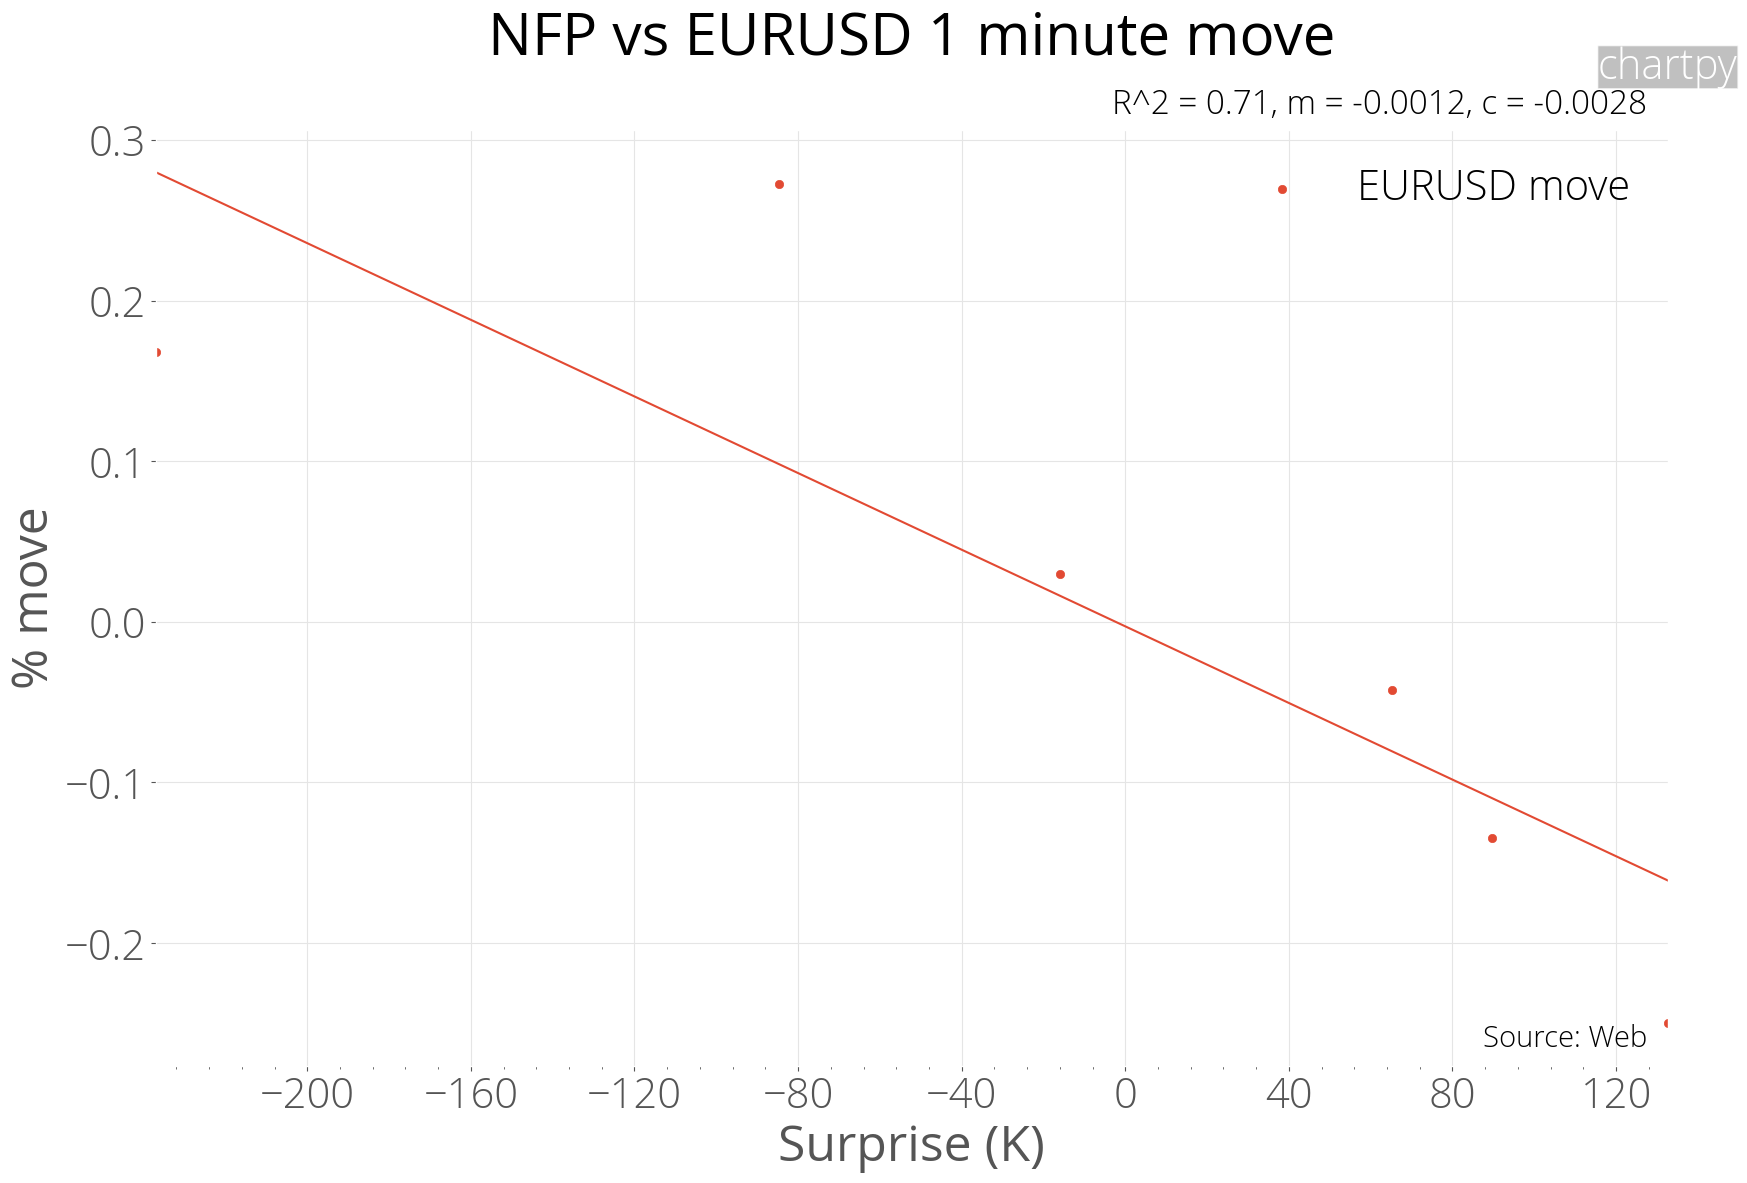

In [44]:
style_nfp = Style(title="NFP vs EURUSD 1 minute move", y_title='% move', 
                  x_title='Surprise (K)', line_of_best_fit=True)

Chart().plot(df_surprise_plot, chart_type='scatter', engine='matplotlib', style=style_nfp)

## Creating a web app to do volatility calculations of FX

### What's the point of creating a front end (eg. web)?


So far all our examples have involved typing in Python code and then producing an output. Sometimes that has been texted based. Other times it has involved created plots using libraries like Plotly or Matplotlib. However, creating applications in this way restricts the user base to developers who are comfortable using Python. In practice, many users will prefer to be shielded from coding. Instead they will want to use a graphical way to interact with applications. Rather than creating your own graphical interface from scratch, we can create web based dashboards using Plotly's Dash library. We can also use xlwings, to use Excel as a GUI to interact with our Python code (we'll show this later).

### What is Dash?

The simplest webpage is static and is made up of HTML tags. Many webpages are dynamic taking in user inputs from the webpage. They then do some processing in the backend and output the results. This type of interact webpage usually requires writing backend code (for example in Python) and also often JavaScript code, which runs in the browser to render interactive plots etc. What if we want to use Python for everything to create such a web dashboard, not only for backend computation (where Python shines, given all its nice features for data science), but also for front end rendering of graphics? Dash is an open source library from Plotly which lets you do this. There are also additional paid for features, but we won't be examining that. It is built on top of Flask, which is a lightweight Python web framework. However, it has additional features and components which make it easy to build web dashboard and display Plotly style charts.

We'll first create a simple "Hello World" style app with Dash. For a comprehensive tutorial for Dash see https://dash.plot.ly/

### Creating the 'Hello World' Dash app

The first step is to make a couple of imports we also need to instantiate the Dash object.

`dash` is the main Python library
(and `jupyter_dash` can be used to run the Dash application in a Jupyter Notebook, which we'll use here)

`dash_core_components` 

* Dash components include `RadioItems` select
* See https://dash.plot.ly/dash-core-components
    
`dash_html_components`

* HTML components which are basically the common HTML tags like `P` which is the pargraph tag `<P></P>` 
* See https://dash.plot.ly/dash-html-components

In [45]:
from dash import Dash
from jupyter_dash import JupyterDash

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

# If you want to use Dash instead of JupyterDash
# app_hello = Dash('HelloWorld')
app_hello = JupyterDash('HelloWorld')

#### Creating a basic layout in Dash

Here we'll create a simple application, which has as inputs radio buttons and then outputs messages on the webpage related to that. This will help us get comfortable with Dash.

We are basically creating the web page formatting by in Python code, rather than writing HTML. Dash will then generate the appropriate HTML and JavaScript underneath so we don't have to do that ourselves. We use both `dash_html_components` for HTML tags and `dash_core_components` which are based on React.

In [46]:
app_hello.layout = html.Div([
    html.H1('Hello World!'),
    dcc.RadioItems(
        id='dropdown-burger',
        options=[{'label': c, 'value': c}
                 for c in ['Whopper', 'Big Mac', 'Honest Burger']],
        value='Whopper'
    ),
    html.Div(id='output-burger'),
    dcc.Dropdown(
        id='dropdown-size',
        options=[{'label': i, 'value': j}
                 for i, j in [('T','triple'), ('D','double'), ('S','single')]],
        value='double'
    ),
    html.Div(id='output-size'),
    dcc.Markdown('''
#### We can also write in Markdown format like we do in Jupyter notebooks!!!

Although note, not everything is supported yet, which works in Jupyter notebooks (like LaTeX)

* We can write bullets
    * Like this

Add links like this [Burger King](http://www.burgerking.com).

`point out code`
''')

])


#### Basics of callbacks

We can write callbacks which are triggered when one of the inputs are changed. Below we create a callback which is attached to the `dropdown-burger` box. Based on that input, we output to the `output-burger` HTML Div object.

In [47]:
@app_hello.callback(
    dash.dependencies.Output('output-burger', 'children'),
    [dash.dependencies.Input('dropdown-burger', 'value')])
def callback_color(dropdown_value):
    return "The selected burger is %s." % dropdown_value

The next callback is a bit more complicated, because it relies on two dropdown values `dropdown-burger` and `dropdown-size`.

In [48]:
@app_hello.callback(
    dash.dependencies.Output('output-size', 'children'),
    [dash.dependencies.Input('dropdown-burger', 'value'),
     dash.dependencies.Input('dropdown-size', 'value')])
def callback_size(dropdown_burger, dropdown_size):
    return "The chosen burger is a %s %s one." %(dropdown_size,
                                                  dropdown_burger)

In [49]:
# if you create a Dash application (not Jupyter Dash) run below
# app_hello.run_server()

# To run the website externally
# app_hello.run_server(mode='external')


# To run inside a Jupyter notebook
app_hello.run_server(mode='inline', debug=True, host='127.0.0.1')

To kick off the application we need to run the next line of code, which will load Flask's in built web server. This is fine to use for development purposes and bugging. For production, we should run Flask (and hence Dash) via a proper web server like Apache, Nginx and we can use gunicorn (Python WSGI HTTP Server) underneath. 

This takes a bit more work to do and is beyond the scope of this notebook. We've run our Dash application side a Jupyter notebook. You can also run it inside a Python script, and then view the application via a web browser (you might be able to run this in a Jupyter notebook too, in this way, however, you'll need to make sure to restart the Python kernel each time you want to run this command).

    app_hello.run_server()

### Creating a realized volatilty calculator Dash app

In this case, we modify our original Hello World app. Our application loads of market data from Quandl at startup for G10 FX USD crosses. The user can then select to plot spot data and also realized volatility for a variety of tenors, which is computed on the fly.

To start with we do our various imports. We'd recommend restarting the kernel to clear any other Dash or JupyterDash instances running.

In [50]:
# Imports for Dash
from dash import Dash

import dash
import dash_core_components as dcc
import dash_html_components as html

# Imports for downloading market data and generating charts
from findatapy.market import Market, MarketDataRequest, MarketDataGenerator
from chartpy import Chart, Style

# For scaling realized volatility later
import math

We want to set up our charting. We use chartpy, with plotly as a backend. Dash works nicely with plotly!

In [51]:
# For plotting
style_vol = Style(plotly_plot_mode='dash', title='Realized Volatilty', 
                  width=1000, height=500, scale_factor=1)
style_spot = Style(plotly_plot_mode='dash', title='Spot', 
                   width=1000, height=500, scale_factor=1)
chart = Chart(engine='plotly')

#### Using external stylesheets

Get an external stylesheet to make the formatting nicer.

In [52]:
# external CSS stylesheets
external_stylesheets = [
    'https://codepen.io/chriddyp/pen/bWLwgP.css',
    {
        'href': 'https://stackpath.bootstrapcdn.com/bootstrap/4.1.3/css/bootstrap.min.css',
        'rel': 'stylesheet',
        'integrity': 'sha384-MCw98/SFnGE8fJT3GXwEOngsV7Zt27NXFoaoApmYm81iuXoPkFOJwJ8ERdknLPMO',
        'crossorigin': 'anonymous'
    }
]


We need to instantiate the application to start.

In [53]:
app_vol = Dash('RealizedVolatility', external_stylesheets=external_stylesheets)

We define the tickers and their associated Quandl tickers, that we need.

In [54]:
# Tickers
tickers = ['EURUSD', 'USDJPY', 'GBPUSD', 'AUDUSD', 'USDCAD', 
           'NZDUSD', 'USDCHF', 'USDNOK', 'USDSEK']

# Vendor tickers for Quandl for the above currency pairs
vendor_tickers = ['FRED/DEXUSEU', 'FRED/DEXJPUS', 'FRED/DEXUSUK', 'FRED/DEXUSAL',
                  'FRED/DEXCAUS', 'FRED/DEXUSNZ', 'FRED/DEXSZUS', 'FRED/DEXNOUS',
                  'FRED/DEXSDUS']


#### Creating a Dash layout with graphs

Next, we can create the layout using various Dash components, similar to what we did in the HelloWorld app. This time we also use the Graph components, which will be used by for displaying the Plotly charts.

In [55]:
# Create the layout
app_vol.layout = html.Div([

    html.H1('Realised volatility calculator'),

    # Drop down for selecting the asset
    dcc.Dropdown(
        id='dropdown-asset',
        options=[{'label': c, 'value': c}
                 for c in tickers],
        value='EURUSD',
        style={'height': '30px', 'width': '400px'}
    ),
    html.Br(),

    # Radio button for selecting the tenor
    dcc.RadioItems(
        id='dropdown-tenor',
        options=[{'label': i, 'value': j}
                 for i, j in [('1W  ', '5'), ('1M  ', '20'), ('1Y  ', '252')]],
        value='1W'
    ),

    # Description text for the application
    dcc.Markdown('''
#### Realized volatility calculator

* We can select the currency pair
* And also the tenor

The application will then compute realized volatility on the fly.
'''),

    # Plotly chart output
    dcc.Graph(id='graph-vol', 
              style={'height': '500px', 'width': '1000px'}),

    # Plotly spot output
    dcc.Graph(id='graph-spot', 
              style={'height': '500px', 'width': '1000px'}),

], style={'padding-top': '50px', 'padding-left': '50px'})

Create a function for loading the market data. This will only called once and the data will be cached in memory. There is no need to keep on downloading market data which doesn't change (and will just slow down the application!)

In [56]:
def load_data():

    # Download the historical spot data once and store in memory, we'll process later
    market = Market(market_data_generator=MarketDataGenerator())

    market_data_request = MarketDataRequest(
        start_date='01 Jan 2000',       # Start date
        freq='daily',                   # Daily data
        data_source='quandl',           # Use Quandl as data source
        tickers=tickers,                # Ticker (Cuemacro)
        fields=['close'],               # Which fields to download
        vendor_tickers=vendor_tickers,  # Ticker (Quandl)
        vendor_fields=['close'],        # Which Bloomberg fields to download
        cache_algo='internet_load_return') # How to return data

    # You need to type your Quandl API below (or modify the DataCred file)
    # market_data_request.quandl_api_key = None

    df = market.fetch_market(market_data_request)
    df = df.fillna(method='ffill')

    df_ret = df / df.shift(1) - 1

    return df, df_ret

#### Callbacks with multiple outputs

We define the callback which gets triggered whenever we change the selected asset or tenor.

In [57]:
# Here we have multiple outputs, which is a newer feature for in Dash, previously, we could only have one output
@app_vol.callback(
    [dash.dependencies.Output('graph-vol', 'figure'),
    dash.dependencies.Output('graph-spot', 'figure')],
    [dash.dependencies.Input('dropdown-asset', 'value'),
     dash.dependencies.Input('dropdown-tenor', 'value')])
def callback_vol_chart(dropdown_asset, dropdown_tenor):

    print(dropdown_asset + ' ' + dropdown_tenor)
    df_vol = df_ret[dropdown_asset + '.close'].rolling(int(dropdown_tenor)).std() * math.sqrt(252) * 100.0

    return chart.plot(df_vol, style=style_vol), chart.plot(df_spot[dropdown_asset + '.close'], style=style_spot)

Load up the spot data and calculates the spot returns (necessary for calculating realized volatility).

In [58]:
df_spot, df_ret = load_data()

2022-02-03 10:55:12,122 - findatapy.market.datavendorweb - INFO - Request Quandl data
2022-02-03 10:55:12,124 - findatapy.market.datavendorweb - INFO - Request Quandl data
2022-02-03 10:55:12,125 - findatapy.market.datavendorweb - INFO - Request Quandl data
2022-02-03 10:55:12,125 - findatapy.market.datavendorweb - INFO - Request Quandl data
2022-02-03 10:55:14,581 - findatapy.market.datavendorweb - INFO - Completed request from Quandl for ['EURUSD.close']
2022-02-03 10:55:15,256 - findatapy.market.datavendorweb - INFO - Completed request from Quandl for ['GBPUSD.close']
2022-02-03 10:55:15,396 - findatapy.market.datavendorweb - INFO - Request Quandl data
2022-02-03 10:55:15,471 - findatapy.market.datavendorweb - INFO - Request Quandl data
2022-02-03 10:55:15,512 - findatapy.market.datavendorweb - INFO - Completed request from Quandl for ['AUDUSD.close']
2022-02-03 10:55:15,578 - findatapy.market.datavendorweb - INFO - Completed request from Quandl for ['USDJPY.close']
2022-02-03 10:55

In this case we haven't used JupyterDash, so we'll need to run it separately. Recall that we might have problems trying to run multiple Dash instances in the same notebook. The below will keep running till you press the stop button in the Jupyter notebook.

In [59]:
app_vol.run_server()

Dash is running on http://127.0.0.1:8050/

2022-02-03 10:55:21,703 - RealizedVolatility - INFO - Dash is running on http://127.0.0.1:8050/



To start the application we could  run the below separately. We could kick the application off PyCharm and show you the output in a web browser.

    app_vol.run_server()

## xlwings: using Python in Excel, 

### Creating a simple xlwings app

xlwings is a Python based library combined with an Excel add-in and some VBA code, which enables us to call Python functions in Excel, and return the output to Excel. xlwings handles the interaction between Excel and Python. Users might need to write a small amount of VBA code too, but generally from experience it is fairly minimal.

#### Creating your xlwings project

We start the Anaconda Prompt or Terminal, and activate the conda environment we want to use:

    conda activate py38class
    
Then navigate to the folder where we want to create our xlwings project. Now run:

    xlwings quickstart plot_xl

#### Starting Excel with xlwings project
    
This will create a Python file `plot_xl.py` with code that our Excel file will call. It also creates a VBA enabled macro spreadsheet `plot_xl.xlsm`, which has a bunch of VBA, which is generally automatically generated by xlwings.

We can now open `plot_xl.xlsm` in Excel. It will have 2 sheets, Sheet1 and another sheet _xlwings.conf. You will likely need to edit _xlwings.conf to tell xlwings the location of your Python interpreter eg.

    C:\Users\<your-username>\Anaconda3\envs\py38class\python.exe

You will also likely need to add the folder of where `plot_xl` is to the PYTHONPATH cell. Once you have finished editing this, you then need to rename the sheet to xlwings.conf. This will then overwrite the xlwings settings for that particular spreadsheet.

We might need to manually add the xlwings add-in in Excel. On Windows it'll be in a location like:

    C:\Users\<your-username>\Anaconda3\envs\py38class\Lib\site-packages\xlwings\addin
    
xlwings also works on Mac, however, certain features like UDFs (user defined functions) in Excel don't work. Note, you might need to enable the Developer tab in your Excel settings, as in most installations it will be invisible.

#### VBA code from xlwings

By default, xlwings creates a VBA macro `SampleCall`, which in turn calls a Python function `hello_xlwings` in `plot_xl.py`. You can view the code of `SampleCall` by clicking on the Developer tab in Excel, then click on Visual Basic. Then navigate down to VBAProject (plot_xl.xlsm), then to Modules and finally Module1. Then click the play button, and the macro should run. In Sheet1, in cell A1, you'll see Hello xlwings!

In [60]:
import xlwings as xw

def hello_xlwings():
    wb = xw.Book.caller()
    wb.sheets[0].range("A1").value = "Hello xlwings!"

### UDF functions (User defined functions)

You can also create UDF functions to use in Excel for Windows that call Python code to do the computation. To register any UDF functions written in Python, in Excel, we need to click on xlwings on the toolbar, and then click import functions. xlwings will then generate VBA functions which mirror your Python based UDFs. This VBA is placed in a `xlwings_udfs` code module in your spreadsheet, to help control the interaction bewteen Excel and Python.

These are functions that can be called within cells, similar to native Excel functions like VLOOKUP, SUM etc. By default xlwings has a simple UDF function called hello, which is decorated by `@xw.func`.

In [61]:
import xlwings as xw

@xw.func
def hello(name):
    return "hello {0}".format(name)

We can run the `hello` UDF in Excel, by typing in any cell `=hello('Burger King')`. The contents of that cell will then read `hello Burger King`. Obviously, this is a very simple function. However, the whole point is that we can have a complicated computation in Excel, and expose that to be used in Excel, via a thin layer of xlwings.

### Importing Matplotlib Plots into Excel

We can also use xlwings to import charts generated in Python into Excel sheets! The first step is write the Python code in file `plot_xl.xlsm` that will download market data from Quandl and then create a Matplotlib chart. We need to return the Matplotlib `Figure` object from this. Note, we increase the `dpi` (dots per inch) parameter, otherwise the chart will look blurry in Excel later.

In [62]:
def get_figure(ticker, api_key):
    import matplotlib.pyplot as plt
    import quandl

    # Fetch market data from Quandl
    quandl.ApiConfig.api_key = api_key
    df = quandl.get(ticker, start_date="2000-01-01")

    # Plot using Matplotlib
    fig = plt.figure(dpi=300, figsize=(3,2))
    df.plot(ax=plt.gca())

    return fig, df

Then we need to write the Python function that will take in inputs from Excel (in this case the Quandl ticker and the Quandl API key). Note that we can directly read values from Excel cells in Python (we earlier set values of Excel cells from Python). We can then add the Matplotlib figure as a picture in Excel. We also return the Quandl market data which is in a DataFrame to Excel.

In [63]:
def grab_plot():
    # Create a reference to the calling Excel Workbook
    sht = xw.Book.caller().sheets[0]

    # Get the ticker and the API key from Excel
    ticker = sht.range('B2').value
    api_key = sht.range('B50').value

    sht1 = xw.Book.caller().sheets[1]

    # Get the figure and show it in Excel
    fig, df = get_figure(ticker, api_key)
    pic = sht1.pictures.add(fig, name='quandl_fig', update=True)

    # Print raw data
    xw.Book.caller().sheets[1].range("J1").value = df

In order to run this Python function `grab_code` we can add the following code in a VBA module (which looks very similar to `SampleCall`. We create a button which calls this VBA function.

    Sub GrabPlot()
        mymodule = Left(ThisWorkbook.name, (InStrRev(ThisWorkbook.name, ".", -1, vbTextCompare) - 1))
        RunPython ("import " & mymodule & ";" & mymodule & ".grab_plot()")
    End Sub

## Comparing unemployment data across different US states

FRED provides us rich datasets for understanding the US economy, even at a state level. We can browse some of these time series at https://fred.stlouisfed.org/tags/series?t=state%3Bunemployment. We shall download these to understand how unemployment compares across US states.

In [64]:
us_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA",
"HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
"MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
"NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
"SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

us_states_fred = [x + 'UR' for x in us_states]

### Downloading economic data in FRED

Now set up the various Market objects and get the API keys necessary (in particular we shall download from FRED).

In [65]:
# Either set API keys as an environment variable (preferred for security reasons) 
# or replace these below, with your own keys
try:
    import os
    QUANDL_API_KEY = os.environ['QUANDL_API_KEY']
    FRED_API_KEY = os.environ['FRED_API_KEY']
    ALPHA_VANTAGE_API_KEY = os.environ['ALPHA_VANTAGE_API_KEY']
except:
    pass

from findatapy.market import Market, MarketDataGenerator, MarketDataRequest

market = Market(market_data_generator=MarketDataGenerator())

Download the unemployment for US states from FRED.

In [66]:
md_request = MarketDataRequest(
    start_date='01 Jan 2001', # Start date
    finish_date='12 Aug 2019', # Finish date
    tickers=us_states, # What we want the ticker to look like once download
    vendor_tickers=us_states_fred, # The ticker used by the vendor
    fields=['close'], # What fields we want (usually close, we can also define vendor fields)
    data_source='alfred', # What is the data source?
    # vendor_fields=['actual-release', 'first-revision', 'close'],
    fred_api_key=FRED_API_KEY) # Most data sources will require us to specify an API key/password
    
df_fred_une = market.fetch_market(md_request)

2022-02-03 10:55:46,443 - findatapy.market.datavendorweb - INFO - Request ALFRED/FRED data
2022-02-03 10:55:46,445 - findatapy.market.datavendorweb - INFO - Request ALFRED/FRED data
2022-02-03 10:55:46,446 - findatapy.market.datavendorweb - INFO - Request ALFRED/FRED data
2022-02-03 10:55:46,447 - findatapy.market.datavendorweb - INFO - Request ALFRED/FRED data
2022-02-03 10:55:53,385 - findatapy.market.datavendorweb - INFO - Completed request from ALFRED/FRED for ['MI.close', 'MN.close', 'MS.close', 'MO.close', 'MT.close', 'NE.close', 'NV.close', 'NH.close', 'NJ.close', 'NM.close', 'NY.close']
2022-02-03 10:55:53,393 - findatapy.market.datavendorweb - INFO - Request ALFRED/FRED data
2022-02-03 10:55:53,866 - findatapy.market.datavendorweb - INFO - Completed request from ALFRED/FRED for ['NC.close', 'ND.close', 'OH.close', 'OK.close', 'OR.close', 'PA.close', 'RI.close', 'SC.close', 'SD.close', 'TN.close', 'TX.close']
2022-02-03 10:55:53,949 - findatapy.market.datavendorweb - INFO - Com

We can now download the US national unemployment rate, which we'll use later. It's ticker in FRED has a slightly different format.

In [67]:
md_request.tickers = ['US', 'US NSA']; md_request.vendor_tickers = ['UNRATE', 'UNRATENSA']

df_national_une = market.fetch_market(md_request)

2022-02-03 10:55:59,675 - findatapy.market.datavendorweb - INFO - Request ALFRED/FRED data
2022-02-03 10:55:59,677 - findatapy.market.datavendorweb - INFO - Request ALFRED/FRED data
2022-02-03 10:56:00,248 - findatapy.market.datavendorweb - INFO - Completed request from ALFRED/FRED for ['US.close']
2022-02-03 10:56:00,279 - findatapy.market.datavendorweb - INFO - Completed request from ALFRED/FRED for ['US NSA.close']
2022-02-03 10:56:02,332 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_954__abstract_curve_key-None__base_depos_currencies-EUR_GBP_AUD_NZD_USD_CAD_CHF_NOK_SEK_JPY__base_depos_tenor-ON_TN_SN_1W_2W_3W_1M_2M_3M_4M_6M_9M_1Y_2Y_3Y_5Y__category-None__category_key-backtest_default-cat_alfred_daily_NYC__cut-NYC__data_engine-None__data_source-alfred__environment-backtest__expiry_date-NaT__fields-close__finish_date-2019-08-12 00:00:00__freeform_md_request-{}__freq-daily__freq_mult-1__fx_forwards_tenor-ON_TN_SN_1W_2W_3W_1M_2M_3M_4M_6M_9M_1Y_2Y_3Y_5Y__fx_vol_

### Reformat DataFrames and transform

Clean up the columns by removing '.close' from both state level and national unemployment data.

In [68]:
df_fred_une.columns = [x.replace('.close', '') for x in df_fred_une.columns]
df_national_une.columns = [x.replace('.close', '') for x in df_national_une.columns]

print(df_fred_une[0:5])

             AL   AK   AZ   AR   CA   CO   CT   DC   DE   FL  ...   SD   TN  \
Date                                                          ...             
2001-01-01  4.7  6.2  4.0  4.3  4.8  2.7  2.3  5.9  3.6  3.9  ...  2.7  3.9   
2001-02-01  4.8  6.1  4.1  4.4  4.8  2.8  2.4  6.0  3.6  4.0  ...  2.8  4.0   
2001-03-01  4.8  6.1  4.2  4.5  4.9  2.9  2.5  6.1  3.5  4.0  ...  2.8  4.0   
2001-04-01  4.9  6.1  4.2  4.5  5.0  3.1  2.6  6.1  3.4  4.1  ...  2.9  4.1   
2001-05-01  4.9  6.1  4.3  4.6  5.1  3.3  2.7  6.2  3.3  4.2  ...  2.9  4.2   

             TX   UT   VT   VA   WA   WV   WI   WY  
Date                                                
2001-01-01  4.1  3.8  3.0  2.3  5.4  5.3  3.8  3.7  
2001-02-01  4.2  3.9  3.1  2.5  5.5  5.3  3.9  3.7  
2001-03-01  4.3  3.9  3.2  2.6  5.6  5.2  4.0  3.7  
2001-04-01  4.5  4.0  3.2  2.8  5.7  5.2  4.1  3.7  
2001-05-01  4.6  4.1  3.3  2.9  5.7  5.2  4.2  3.8  

[5 rows x 51 columns]


Create a function which extracts the time series for a particular date.

In [69]:
def get_pretty_data(df, index):

    df = pd.DataFrame(df.iloc[index]).transpose()
    
    return df

Get the latest data, and data during the financial crisis in 2009. We can then compare these.

In [70]:
import pandas as pd

df_last = get_pretty_data(df_fred_une, -1)
df_first = get_pretty_data(df_fred_une, 12*8)

df = df_last.append(df_first)

print(df)

             AL   AK   AZ   AR   CA   CO   CT   DC   DE   FL  ...   SD   TN  \
2019-08-01  2.8  5.4  4.8  3.5  4.1  2.6  3.6  5.2  3.7  3.3  ...  3.0  3.3   
2009-01-01  8.4  7.2  8.2  7.0  9.9  6.6  7.1  8.7  7.2  7.8  ...  4.1  8.7   

             TX   UT   VT   VA   WA   WV   WI   WY  
2019-08-01  3.5  2.5  2.3  2.6  4.1  4.9  3.4  3.8  
2009-01-01  6.1  6.1  5.5  5.7  6.8  6.5  7.4  4.2  

[2 rows x 51 columns]


Sort the data by the first date in our sample and then transpose to get it ready for plotting.

In [71]:
df_sorted = df.sort_values(df.index[0],axis=1)
df_sorted = df_sorted.transpose()

### Plotting unemployment across US states

Now plot the time series! Perhaps unsurprisingly, we can see the unemployment has fallen considerably since the financial crisis, across all US states, in some cases halving. For certain states like Arkansas, currently with the highest rate of unemployment has not changed that much.

In [72]:
from chartpy import Chart, Style

# note that chartpy has its own different styling for Matplotlib charts
style = Style(title='US state UNE', 
              width=300, height=150, source='FRED', plotly_plot_mode='offline_jupyter')
style.chart_type = 'bar'
Chart(engine='plotly').plot(df_sorted, style=style);

For comparison let's plot the time series for US and Alaska. US national unemployment exhibits far more volatility. We also plot the not seasonally adjusted unemployment data. We can see fairly obvious seasonality from the time series. Typically, market participants use seasonally adjusted economic data. FRED often offers both seasonally adjusted and not seasonally adjusted data.

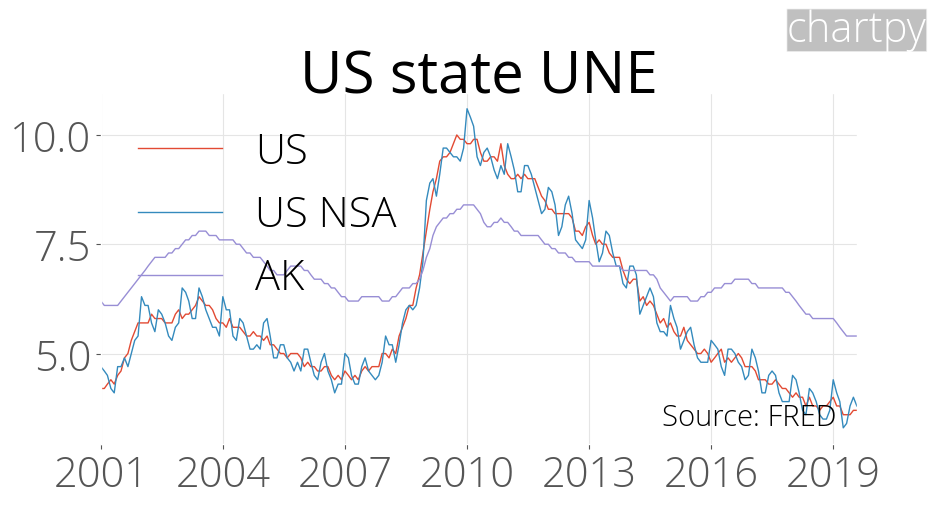

In [73]:
df_national_ak = df_national_une.copy()
df_national_ak['AK'] = df_fred_une['AK']

style.chart_type = 'line'
Chart(engine='matplotlib').plot(df_national_ak, style=style)

### Using Prophet to forecast the US unemployment rate

Facebook has created a library for time series prediction called Prophet. We can install this in conda in our Python environment. It also installs all the dependencies including pystan. Note, that it is much easier to install in conda than using pip (espeically in Windows, as it needs a compiler). A detailed tutorial for Prophet is available at https://facebook.github.io/prophet/docs/quick_start.html

    conda install -c conda-forge pystan fbprophet --yes

First import Prophet. We also need to reformat the DataFrame so it can be used by Prophet, we need all dates in the `ds` column and values in the `y` column. We are using the unemployment data which is not seasonally adjusted.

In [74]:
from fbprophet import Prophet

df_national_y_ds = df_national_une['US NSA'].copy()
df_national_y_ds = df_national_y_ds.reset_index()

df_national_y_ds.columns = ['ds', 'y']

print(df_national_y_ds[0:5])

          ds    y
0 2001-01-01  4.7
1 2001-02-01  4.6
2 2001-03-01  4.5
3 2001-04-01  4.2
4 2001-05-01  4.1


Fit the model. We also specify an interval width for uncertainty. Prophet can be used to model daily, weekly and monthly seasonality in data. Our data is monthly, hence, clearly wouldn't be able to tell any daily/weekly seasonality.

In [75]:
m = Prophet(interval_width=0.95)
m.fit(df_national_y_ds)

2022-02-03 10:56:06,297 - fbprophet - INFO - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-02-03 10:56:06,298 - fbprophet - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Create a future dataframe, and we wish to predict across these future dates. Given we are using monthly data, we have used the `MS` keyword for frequency.

In [76]:
future = m.make_future_dataframe(periods=36, freq='MS')
future.tail()

ds
255 2022-04-01
256 2022-05-01
257 2022-06-01
258 2022-07-01
259 2022-08-01

Create a forecast, with lower and upper bounds.

In [77]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
255 2022-04-01  0.815284   -0.877841    2.333905
256 2022-05-01  0.789979   -0.996783    2.514351
257 2022-06-01  1.192541   -0.463180    2.939540
258 2022-07-01  1.207927   -0.605567    2.949297
259 2022-08-01  0.953058   -0.797778    2.819952

We can plot the forecast using Matplotlib. The forecast seems to follow the same path and it's captured the seasonality in our forecast. Note, we can't get a negative unemployment rate (the confidence band appears to dip into negative territory)! This illustrates that don't just use models as a black box. The output needs to make sense. Prophet also has other models which you can play with and parameters to change, which we might be able to use to improve the forecast. Clearly, the model is basically just expecting a continuation in the trend, and is unlikely to be quite as good as picking out turning points.

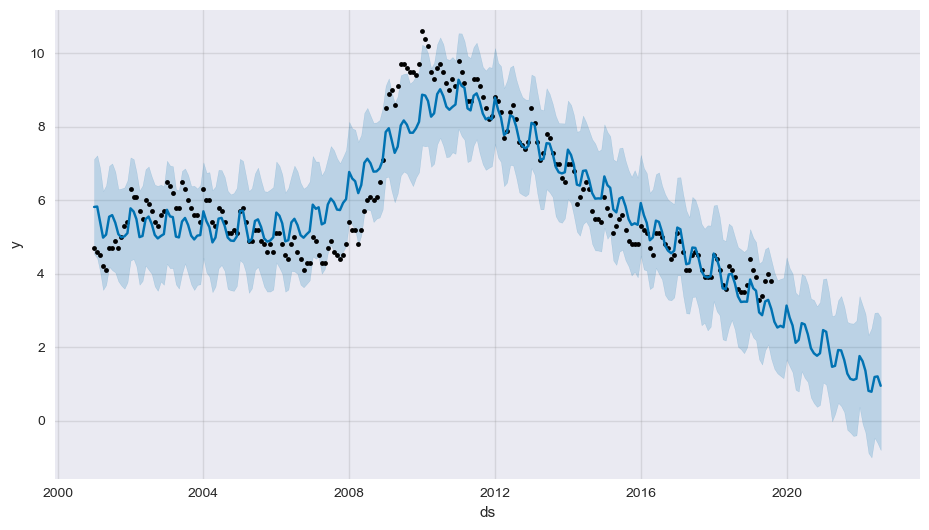

In [78]:
import matplotlib.pyplot as plt

plt.style.use('seaborn') # changes the matplotlibplot style...

fig1 = m.plot(forecast)

We can see the trend and seasonal components of our forecast. We can see the trend broadly seems inline with the smoothed unemployment. There seems particularly pronounced seasonality in the earlier part of the year.

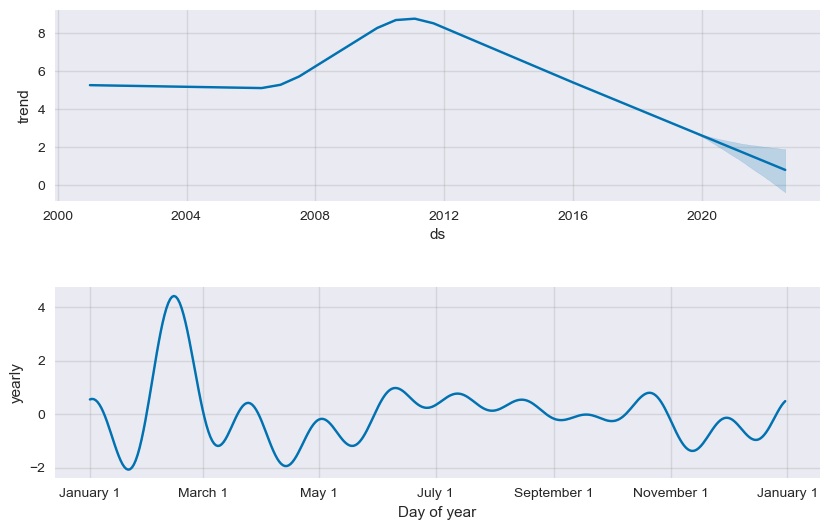

In [79]:
fig = m.plot_components(forecast)

### Using Statsmodels for decomposing time series

We saw Statsmodels earlier in the course, where we used it to do linear regressions. We can also use it to decompose time series into it's various components: trend, seasonality and noise (similar to what we did earlier with Prophet). As a first step we import the library.

In [80]:
import statsmodels.api as sm

We now run the decomposition for the US unemployment rate which hasn't been seasonally adjusted.

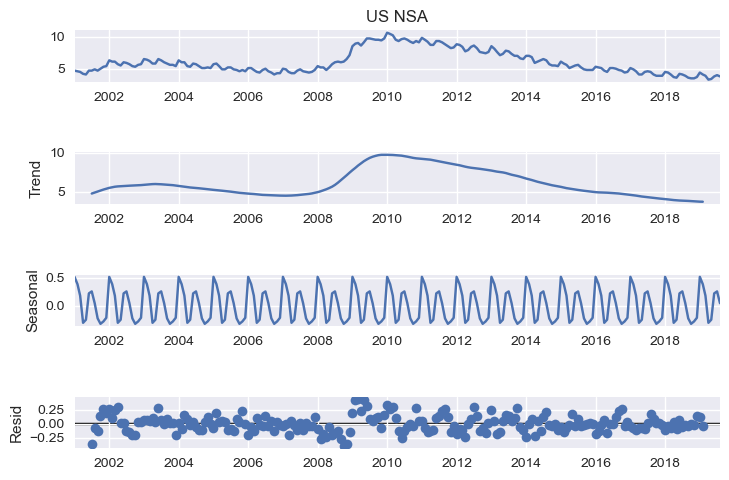

In [81]:
decomposition = sm.tsa.seasonal_decompose(df_national_une['US NSA'].copy(), model='additive')

fig = decomposition.plot()
plt.show()

If we repeat the exercise for the seasonally adjusted US unemployment rate, we note (as expected!) that the seasonal component is much smaller.

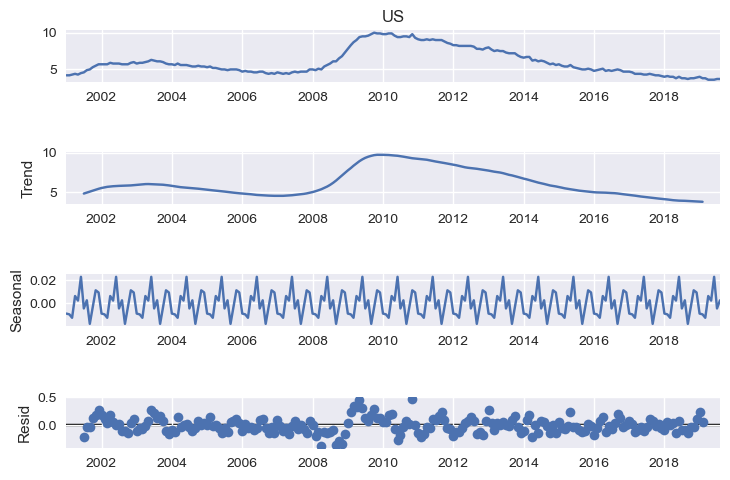

In [82]:
decomposition = sm.tsa.seasonal_decompose(df_national_une['US'].copy(), model='additive')

fig = decomposition.plot()
plt.show()

## Exploring seasonality in EUR/USD, USD/JPY and US Treasury 10Y yields

Why might we expect markets to exhibit seasonality? Here are several different explanations, which could explain why certain markets could have these patterns. Note, we need to look at data to verfiy these hypotheses.

* For certain commodities it is likely that weather patterns will have a direct impact, such as grains etc.
* There are likely to be patterns in economic data!
    * Summer holidays
    * Christmas holidays
* Market flows around certain times of year, when firms need to repatriate income (eg. from abroad)
* Remittances around holidays
* Spending budgets before quarter ends

We can also try to understand seasonality in market data, as well as economic data. Obviously in this instance, we can explore seasonality at a higher frequency. In this case we are exploring seasonality on EUR/USD, USD/JPY spot and US 10Y Treasury yields. As a first step, as usual, we need to get access to the data. We use Quandl as our source.

In [83]:
# Either set API keys as an environment variable (preferred for security reasons) 
# or replace these below, with your own keys
try:
    import os
    QUANDL_API_KEY = os.environ['QUANDL_API_KEY']
except:
    pass

from findatapy.market import Market, MarketDataGenerator, MarketDataRequest

md_request = MarketDataRequest(
    start_date='01 Jan 1990', # Start date
    tickers=['EURUSD', 'USDJPY', 'UST10Y_YIELD'], # What we want the ticker to look like once download
    vendor_tickers=['FRED/DEXUSEU', 'FRED/DEXJPUS', 'FRED/DGS10'], # The ticker used by the vendor
    fields=['close'], # What fields we want (usually close, we can also define vendor fields)
    data_source='quandl', # What is the data source?
    # vendor_fields=['actual-release', 'first-revision', 'close'],
    quandl_api_key=QUANDL_API_KEY) # Most data sources will require us to specify an API key/password

market = Market()
df_market = market.fetch_market(md_request)
df_market = df_market.fillna(method='ffill')

2022-02-03 10:56:09,953 - findatapy.market.datavendorweb - INFO - Request Quandl data
2022-02-03 10:56:09,956 - findatapy.market.datavendorweb - INFO - Request Quandl data
2022-02-03 10:56:09,956 - findatapy.market.datavendorweb - INFO - Request Quandl data
2022-02-03 10:56:11,351 - findatapy.market.datavendorweb - INFO - Completed request from Quandl for ['EURUSD.close']
2022-02-03 10:56:13,223 - findatapy.market.datavendorweb - INFO - Completed request from Quandl for ['UST10Y_YIELD.close']
2022-02-03 10:56:13,362 - findatapy.market.datavendorweb - INFO - Completed request from Quandl for ['USDJPY.close']
2022-02-03 10:56:15,421 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_872__abstract_curve_key-None__base_depos_currencies-EUR_GBP_AUD_NZD_USD_CAD_CHF_NOK_SEK_JPY__base_depos_tenor-ON_TN_SN_1W_2W_3W_1M_2M_3M_4M_6M_9M_1Y_2Y_3Y_5Y__category-None__category_key-backtest_default-cat_quandl_daily_NYC__cut-NYC__data_engine-None__data_source-quandl__environment-back

Let's have a quick look at the data we have downloaded. Why is EURUSD NaN during this period? Answer later!

In [84]:
df_market.head(5)

EURUSD.close  USDJPY.close  UST10Y_YIELD.close
Date                                                      
1990-01-02           NaN    146.250000                7.94
1990-01-03           NaN    145.699997                7.99
1990-01-04           NaN    143.369995                7.98
1990-01-05           NaN    143.820007                7.99
1990-01-08           NaN    144.100006                8.02

### Creating a seasonal function with Prophet

We can write a helper function, that takes in a DataFrame, and puts it into the appropriate format. It will then use Prophet to fit the model, and then show the seasonality component. We are ignoring trying to plot any trend component here.

In [85]:
def plot_seasonality(df):
    import matplotlib.pyplot as plt

    plt.style.use('seaborn') # changes the matplotlibplot style...
    
    df_y_ds = df.copy()
    df_y_ds = df_y_ds.reset_index()

    df_y_ds.columns = ['ds', 'y']
    
    from fbprophet import Prophet
    from fbprophet.plot import plot_yearly

    m = Prophet(interval_width=0.95)
    m.fit(df_y_ds)
    plot_yearly(m)

### Plotting seasonality

Let's plot the seasonality component of USDJPY spot. There seem to be some obvious seasonal patterns here. Spot rises going into April and then falls towards November, before rising into Christmas. It should be noted that the Japanese fiscal year starts in April. Hence, there is a rationale for why USDJPY would rise into this. Japan is a large exporter, hence, it is likely that many of these exporting businesses will want to repatirate foreign currency (eg. USD) into JPY before the fiscal year end. What type of trading rule could we create based on this observation?

2022-02-03 10:56:15,493 - fbprophet - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


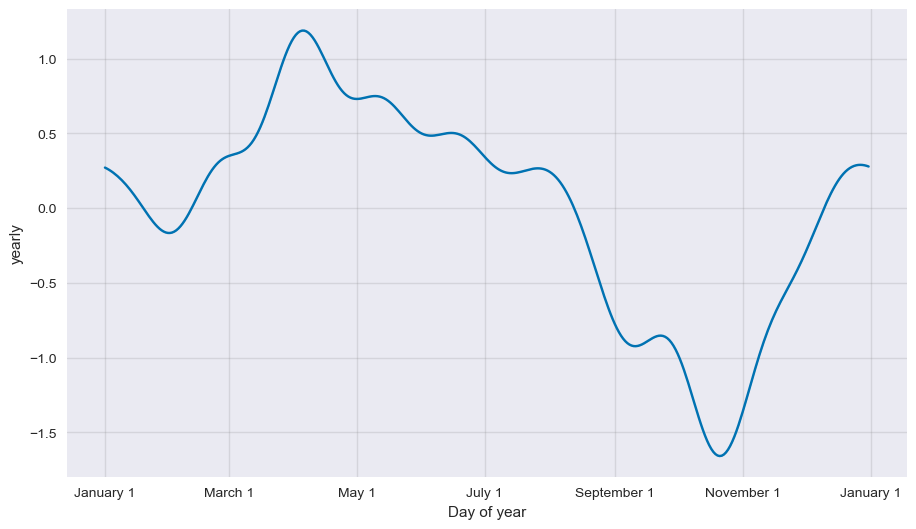

In [86]:
plot_seasonality(df_market['USDJPY.close'])

Let's do the same thing for US 10Y Treasury yields.. looks familiar doesn't it, although we don't have the peak in April, like in USD/JPY.

2022-02-03 10:56:57,386 - fbprophet - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


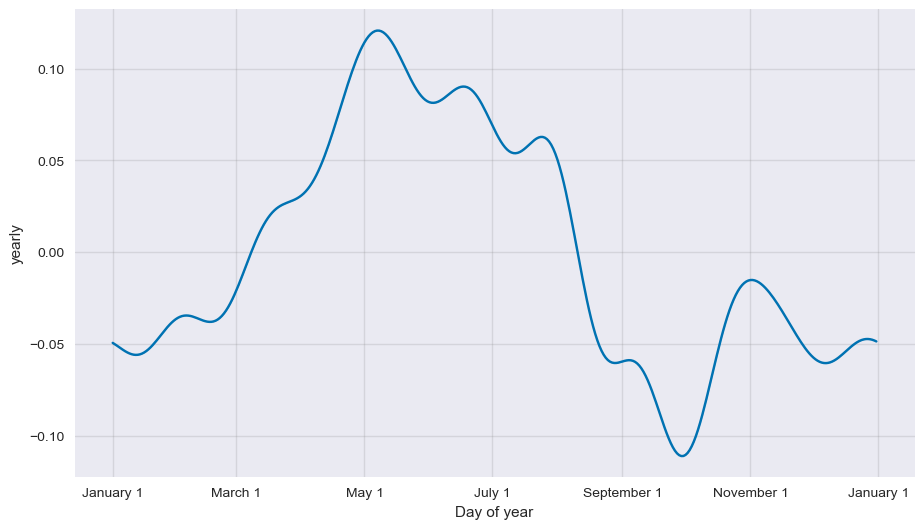

In [87]:
plot_seasonality(df_market['UST10Y_YIELD.close'])

Lastly let's plot the seasonality pattern for EURUSD (we have done it from 1999, which is the introduction date of the Euro). We could have tried to plot it before using proxies (eg. DEM). The most notable seasonal pattern appears to be at the start and end of the year. However, during the year there isn't so much of an obvious direction.

2022-02-03 10:57:33,282 - fbprophet - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


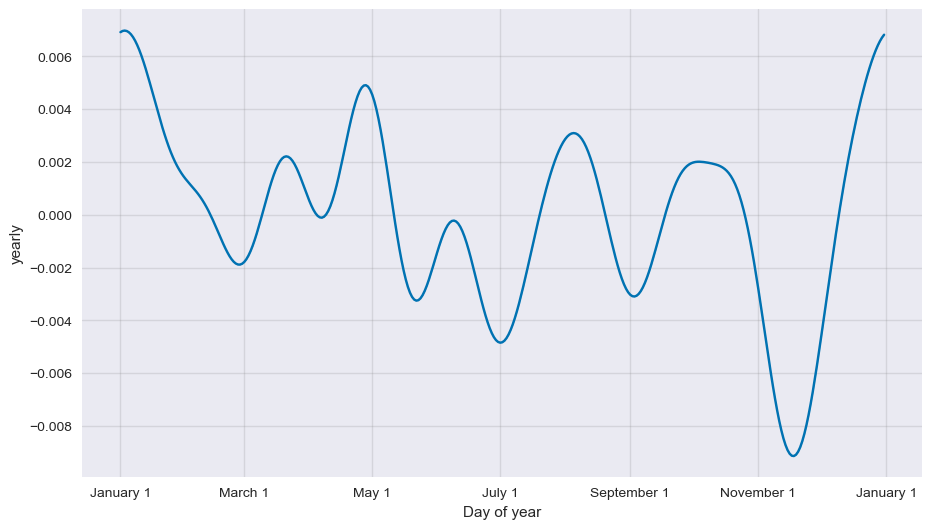

In [88]:
plot_seasonality(df_market['EURUSD.close'][df_market.index > '04 Jan 1999'])

If we plot both USDJPY spot and US 10Y Treasury yields on the same chart, we do need note some correlation between the series. 

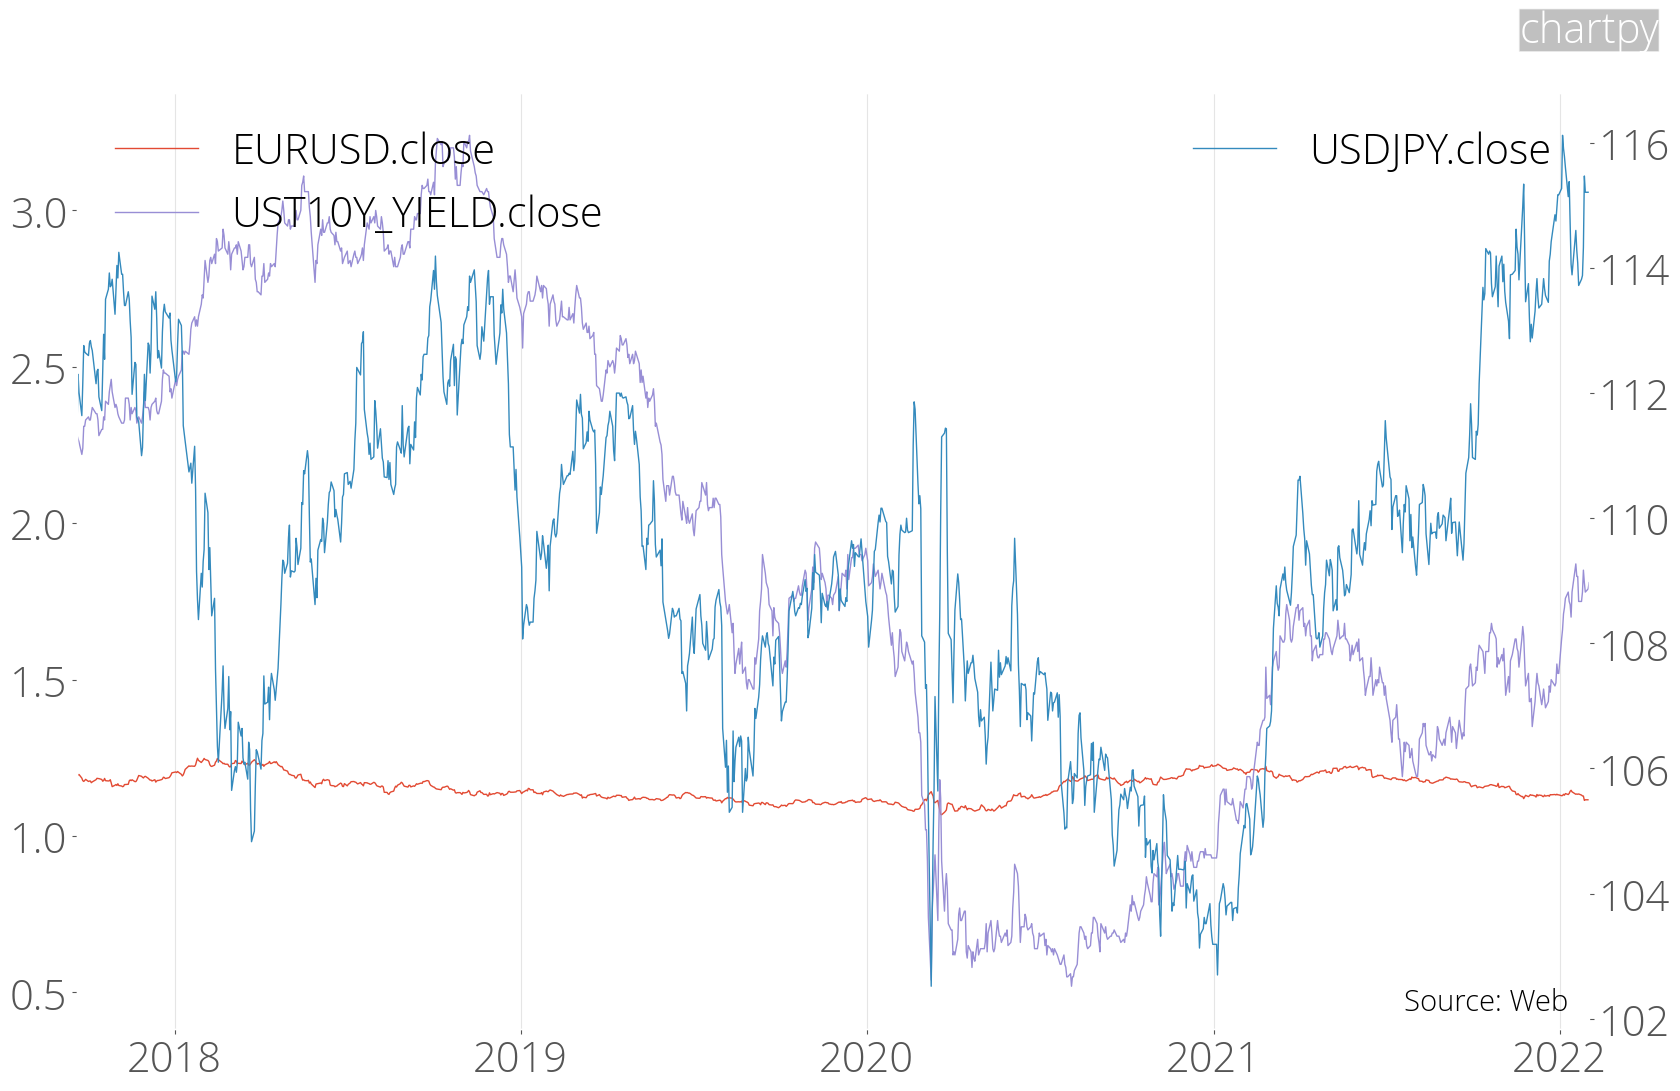

In [89]:
from chartpy import Chart, Style

style=Style(y_axis_2_series='USDJPY.close', y_axis_showgrid=False, y_axis_2_showgrid=False)

Chart(engine='matplotlib').plot(df_market.tail(n=365*3), style=style)

To understand how the relationship between USDJPY and US 10Y Yields changes over time we can plot the daily rolling correlation between the two time series. We shall look at returns for USDJPY and change in US 10Y yields (as they are already a percentage) using 20 working days as our period (ie. 1 month). We'll use pandas in-built plotting via Matplotlib. We see that during most of our sample the correlation is relatively positive. As noted 2018 it does go well into negative territory (as in 2015).

<AxesSubplot:xlabel='Date'>

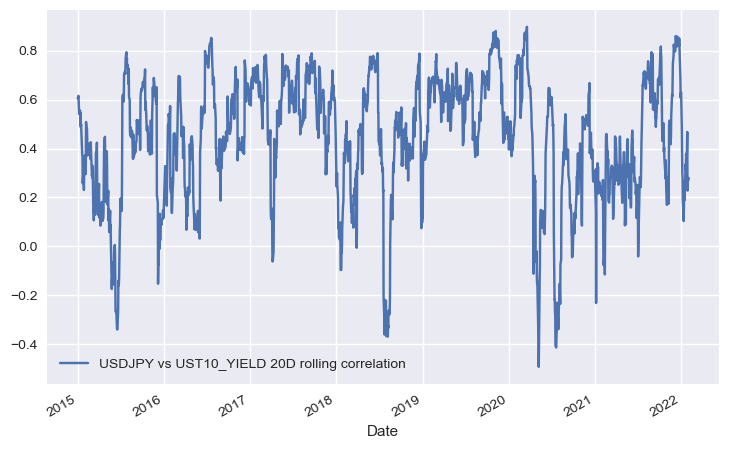

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate spot returns and yield changes
df_spot_returns = df_market['USDJPY.close'] / df_market['USDJPY.close'].shift(1) - 1.0
df_yield_changes = df_market['UST10Y_YIELD.close'] - df_market['UST10Y_YIELD.close'].shift(1)

# Calculate rolling correlation with Pandas
df_corr = pd.DataFrame(df_spot_returns.rolling(20).corr(df_yield_changes))
df_corr.columns = ['USDJPY vs UST10_YIELD 20D rolling correlation']
df_corr = df_corr[df_corr.index > '01 Jan 2015']

# Now plot
plt.style.use('seaborn') # changes the matplotlibplot style...

df_corr.plot()

### Why might USDJPY spot and US 10Y Treasury yields be correlated?

We have seen that USDJPY spot and US 10Y yields are generally very positively correlated over time. One explanation is related to relative monetary policy, which can be seen as a proxy for relative growth expectations between two economies (in this case US and Japan). When the Fed becomes more hawkish, typically Treasury yields rise as the market reprices expectations of growth and inflation. Conversely a dovish Fed, would generally see yields lower. Generally, JGB (Japanese Government Bond) yields have been so low for so long as a result of BoJ monetary policy, that they tend to have less impact on the cross. (There's only so much the BoJ can do to turn on the monetary taps, given where 10Y JGB yields are.. see below for a comparison with UST 10 yields).

Relative monetary policy expectations have traditionally been an important driver for G10 FX (eg. EURUSD). However, in recent years for many FX crosses the relationship has been less strong. Even for USDJPY, we see there were periods when there's been a big divergence, between spot and yields, in 2018.

There are also other explanations for why USDJPY in particular seems to move with UST yields. One is related to the options markets. Many banks have large USDJPY exotic options structures which are long dated, which they are actively hedging. These long dated options tend to have a larger amount of sensitivity to moves in the rates market (options prices are depend on many factors such as spot, volatility - in particular, rates etc.) Hence, moves higher in UST yields, mean that many of these players need to buy USDJPY to readjust their hedges. They need to sell USDJPY to readjust their hedges, when UST 10 year yields fall. 

It's difficult to know for certain what the specific driver is, although these are the reasons I've heard from colleagues engaged both in the spot and options market. If you have any specific ideas let me know about this!

2022-02-03 10:58:06,953 - findatapy.market.datavendorweb - INFO - Request ALFRED/FRED data
2022-02-03 10:58:06,955 - findatapy.market.datavendorweb - INFO - Request ALFRED/FRED data
2022-02-03 10:58:07,641 - findatapy.market.datavendorweb - INFO - Completed request from ALFRED/FRED for ['JGB10Y_YIELD.close']
2022-02-03 10:58:08,457 - findatapy.market.datavendorweb - INFO - Completed request from ALFRED/FRED for ['UST10Y_YIELD.close']
2022-02-03 10:58:10,522 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_855__abstract_curve_key-None__base_depos_currencies-EUR_GBP_AUD_NZD_USD_CAD_CHF_NOK_SEK_JPY__base_depos_tenor-ON_TN_SN_1W_2W_3W_1M_2M_3M_4M_6M_9M_1Y_2Y_3Y_5Y__category-None__category_key-backtest_default-cat_alfred_daily_NYC__cut-NYC__data_engine-None__data_source-alfred__environment-backtest__expiry_date-NaT__fields-close__finish_date-2022-02-03 10:54:47_877924__freeform_md_request-{}__freq-daily__freq_mult-1__fx_forwards_tenor-ON_TN_SN_1W_2W_3W_1M_2M_3M_4M_6M_

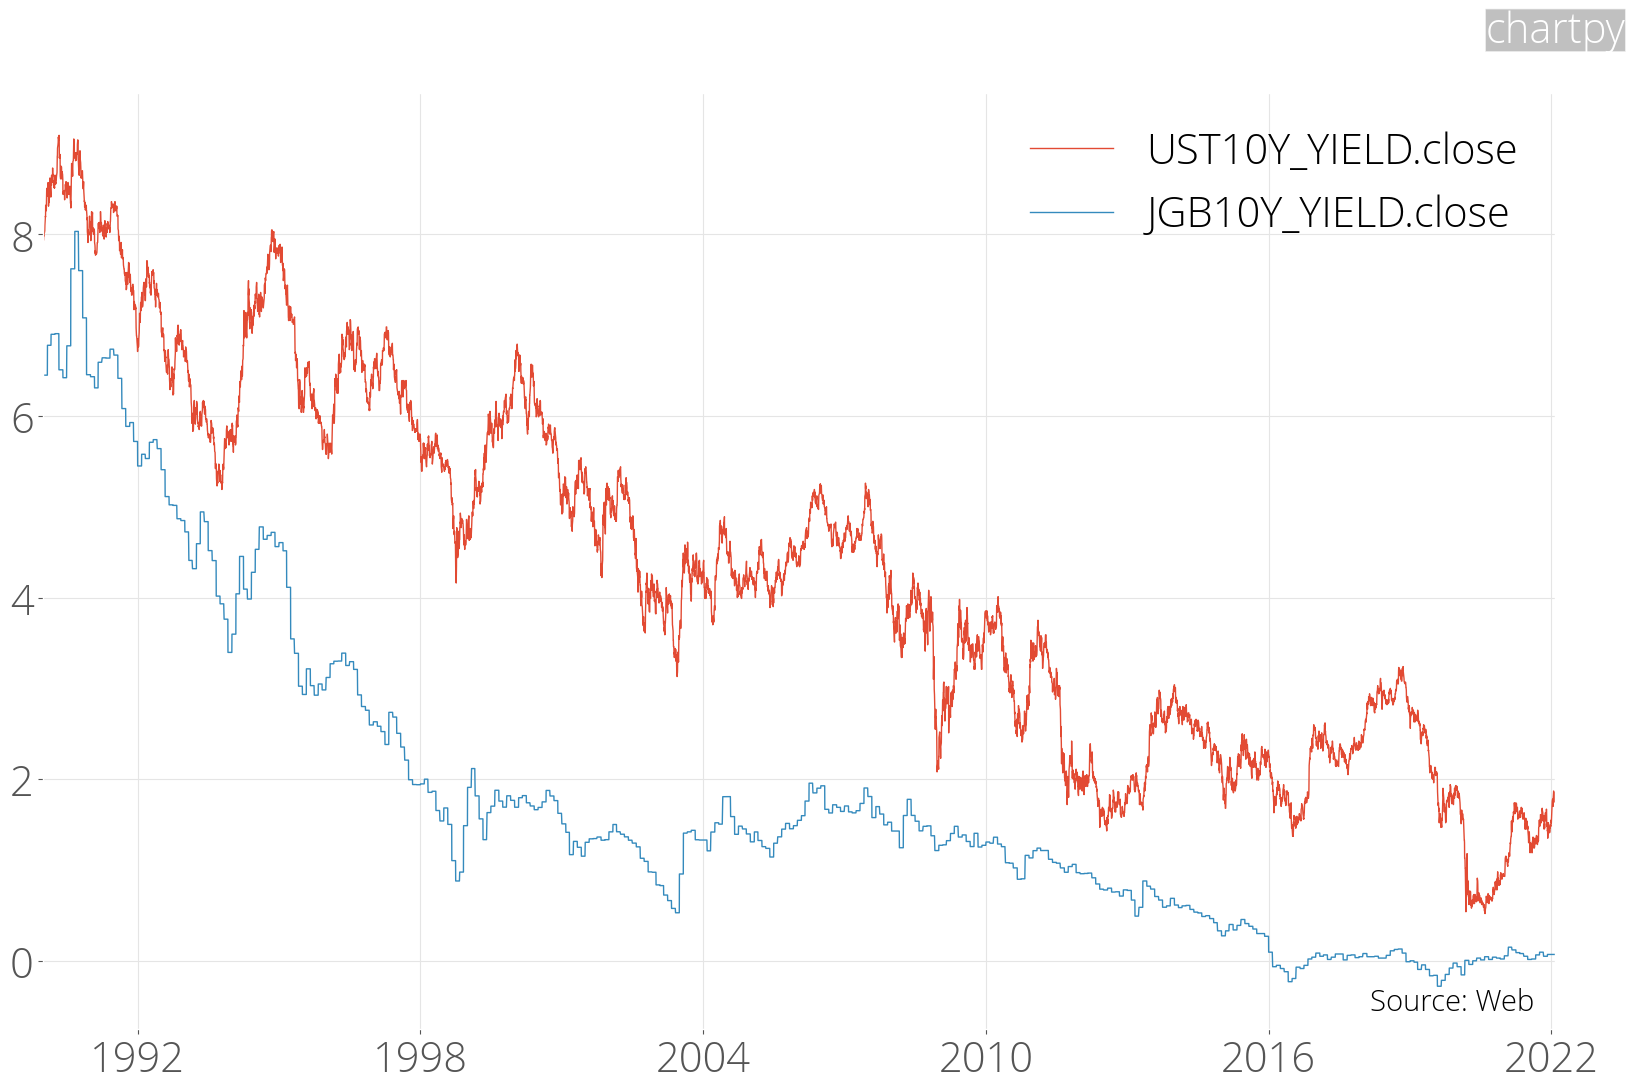

In [91]:
md_request = MarketDataRequest(
    start_date='01 Jan 1990', # Start date
    tickers=['UST10Y_YIELD', 'JGB10Y_YIELD'], # What we want the ticker to look like once download
    vendor_tickers=['DGS10', 'IRLTLT01JPM156N'], # The ticker used by the vendor
    fields=['close'], # What fields we want (usually close, we can also define vendor fields)
    data_source='alfred', # What is the data source?
    # vendor_fields=['actual-release', 'first-revision', 'close'],
    fred_api_key=FRED_API_KEY) # Most data sources will require us to specify an API key/password
    
df_yields = market.fetch_market(md_request).fillna(method='ffill')

Chart(engine='matplotlib').plot(df_yields)

## Growth against stocks?

We do a very simple case study, to see if growth is related to moves in stocks in a line chart. We first download US GDP (quarter-on-quarter) changes and alongside that also Dow Jones Industrial Average data from FRED.

In [92]:
md_request = MarketDataRequest(
    start_date='01 Jan 2010', # Start date
    tickers=['DJIA'], # What we want the ticker to look like once download
    vendor_tickers=['DJIA'], # The ticker used by the vendor
    fields=['close'], # What fields we want (usually close, we can also define vendor fields)
    data_source='alfred', # What is the data source?
    fred_api_key=FRED_API_KEY) # Most data sources will require us to specify an API key/password

market = Market(market_data_generator=MarketDataGenerator())
    
df_djia = market.fetch_market(md_request)
df_djia = df_djia.fillna(method='ffill')

md_request.tickers = ["US GDP QoQ SA"]
md_request.vendor_tickers = ["A191RL1Q225SBEA"]

df_gdp = market.fetch_market(md_request)
df_gdp = df_gdp.fillna(method='ffill')

2022-02-03 10:58:11,047 - findatapy.market.datavendorweb - INFO - Request ALFRED/FRED data
2022-02-03 10:58:11,922 - findatapy.market.datavendorweb - INFO - Completed request from ALFRED/FRED for ['DJIA.close']
2022-02-03 10:58:13,966 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_796__abstract_curve_key-None__base_depos_currencies-EUR_GBP_AUD_NZD_USD_CAD_CHF_NOK_SEK_JPY__base_depos_tenor-ON_TN_SN_1W_2W_3W_1M_2M_3M_4M_6M_9M_1Y_2Y_3Y_5Y__category-None__category_key-backtest_default-cat_alfred_daily_NYC__cut-NYC__data_engine-None__data_source-alfred__environment-backtest__expiry_date-NaT__fields-close__finish_date-2022-02-03 10:54:47_877924__freeform_md_request-{}__freq-daily__freq_mult-1__fx_forwards_tenor-ON_TN_SN_1W_2W_3W_1M_2M_3M_4M_6M_9M_1Y_2Y_3Y_5Y__fx_vol_part-V_25R_10R_25B_10B__fx_vol_tenor-ON_1W_2W_3W_1M_2M_3M_4M_6M_9M_1Y_2Y_3Y_5Y__gran_freq-None__list_threads-1__old_tickers-DJIA__push_to_cache-True__resample-None__resample_how-last__split_request_chunks

We'll resample the US GDP data, so that the date will refer to the end of the quarter.

In [93]:
df_gdp_resample = df_gdp.resample("Q").last()
df_gdp_resample.head(5)

US GDP QoQ SA.close
Date                           
2010-03-31                  2.0
2010-06-30                  3.9
2010-09-30                  3.1
2010-12-31                  2.1
2011-03-31                 -1.0

We can do the same thing with DJIA daily data, so both datasets should now have the same frequency

In [94]:
df_djia_resample = df_djia.resample("Q").last()
df_djia_resample = df_djia_resample / df_djia_resample.shift(1) - 1.0
df_djia_resample.head(5)

DJIA.close
Date                  
2012-03-31         NaN
2012-06-30   -0.025125
2012-09-30    0.043248
2012-12-31   -0.024781
2013-03-31    0.112514

Join the two time series, rescaling percentage returns on DJIA by 100, so it's consistent with US GDP QoQ. We'll strip the first point of DJIA which is undefined (we could have got earlier data though from another data source).

In [95]:
df_market_econ = (df_djia_resample * 100.0).join(df_gdp_resample)
df_market_econ = df_market_econ[1:-1]
df_market_econ.head(5)

DJIA.close  US GDP QoQ SA.close
Date                                       
2012-06-30   -2.512485                  1.8
2012-09-30    4.324818                  0.7
2012-12-31   -2.478135                  0.4
2013-03-31   11.251413                  3.5
2013-06-30    2.270865                  0.6

Lastly, let's plot both time series, on different axes and compare. There does appear to be some sort of relationship, however, it is not as clearcut as you might think. Note, that we left off 2008.. what do you think the chart would like there for both?

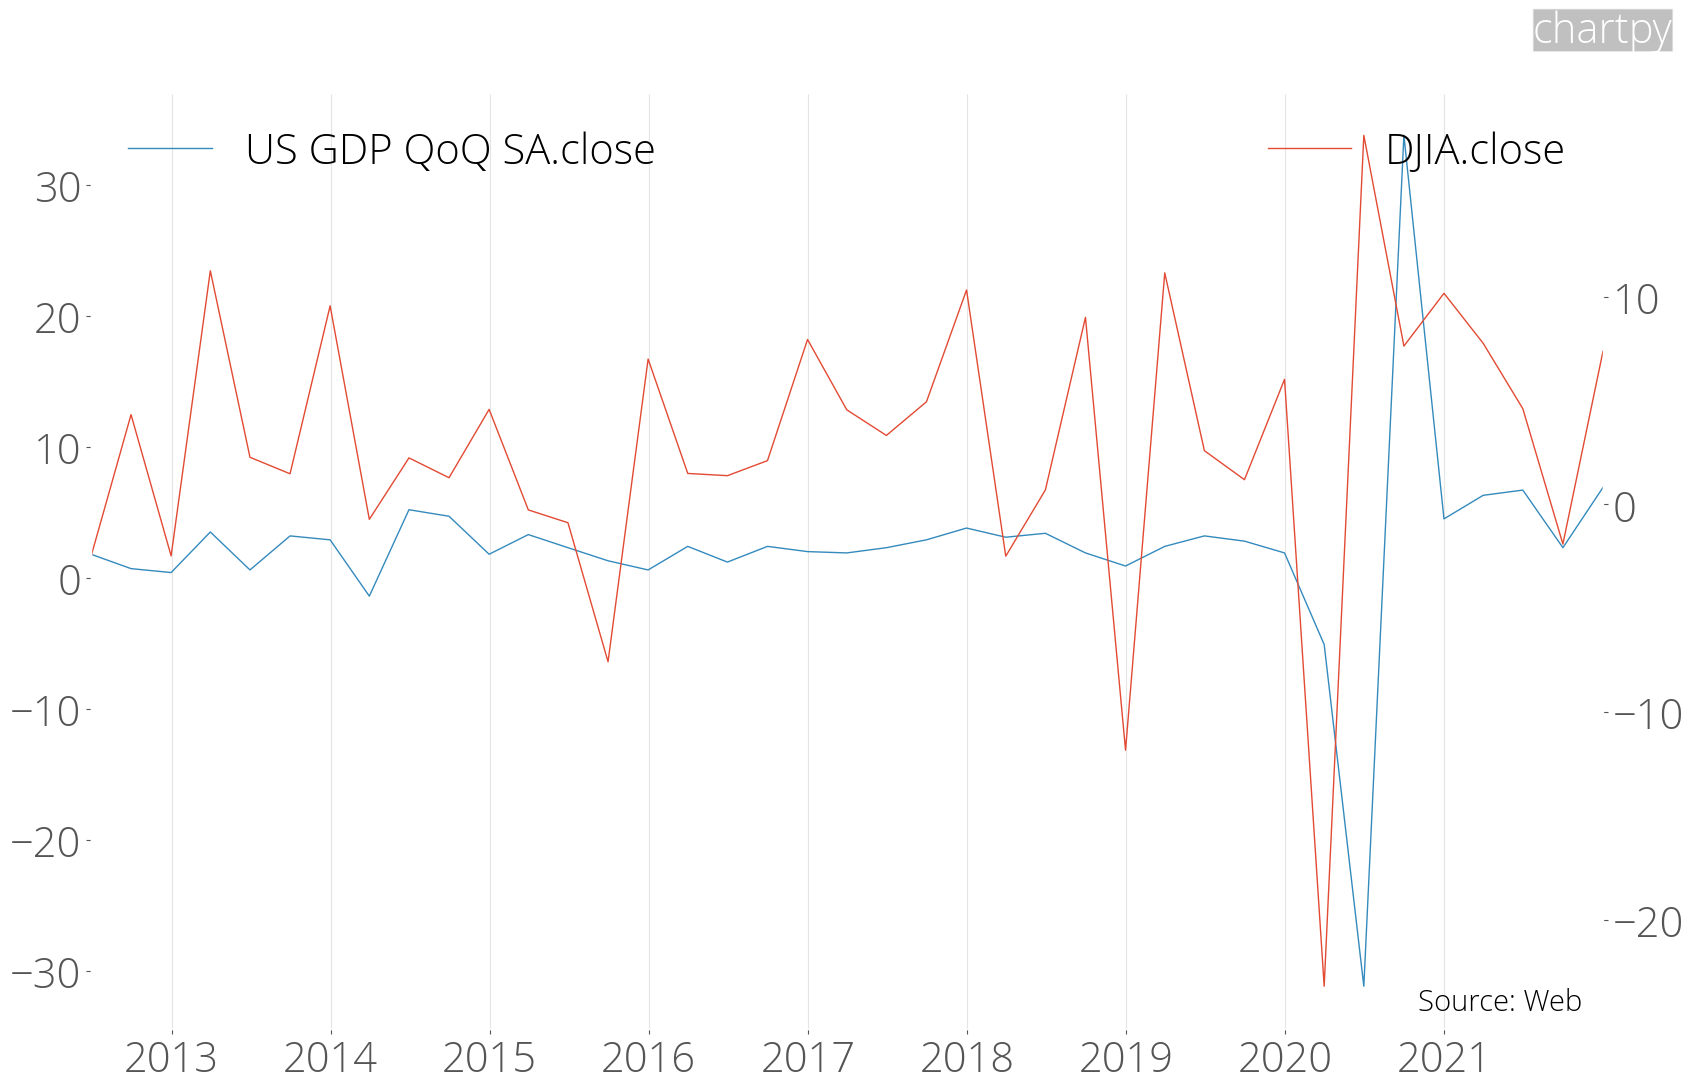

In [96]:
from chartpy import Chart, Style

style=Style(y_axis_2_series='DJIA.close', y_axis_showgrid=False, y_axis_2_showgrid=False)

Chart(engine='matplotlib').plot(df_market_econ, style=style)

## Tutorial: Financial market case studies using Python

You can now do your own case study for financial markets using Python!

### Playing with tick data

* Download a few days of USDJPY data from DukasCopy (eg. 01 Jan 2019 - 05 Jan 2019)
* Calculate the mid price from the tick data (and print first few elements)
* Resample into hourly buckets (based on the open value of the hour)
* Plot the hourly data mid
* Calculate the open, high, low, close of the mid (from the tick data) in hourly buckets
* Then plot the open, high, low and close in hourly buckets and plot on a chart

### Running Hello World Dash web app on your machine

* Start the Dash web app HelloWorld on your machine (app_hello) - you can copy and paste the code from the notes
* Create a very similar Dash web app HelloWorldModified (app_hello_modified)
    * Try modifying the dropdown parameters and the outputs (can we change the options for a pizza restaurant?)
    * Also try changing the markdown on the sheet and rerun
    * Create additional dropdowns with call backs for restaurant location and display the output in a cell
    
### Create a front end for plotting US state level unemployment data with Dash

* Create an interactive Dash app or xlwings to plot the state unemployment data for each state
* There should be a dropdown box to select the state and also to select start and finish dates

### Creating an interactive event study for economic data events with Dash

* We earlier showed how to do an event study to show how FX behaves on a high frequency basis around events like nonfarm payrolls and ECB
* We also showed how to create an interactive Dash application to calculate and display realized volatiliy
* Can you also plot the price action around ECB meetings too? You'll need to find the dates and times of ECB meetings from ECB website first and create a CSV with them as an input (or try Cuemacro's GitHub teaching portal https://github.com/cuemacro/teaching/tree/master/pythoncourse/data)
* Create an interactive Dash applications which can be used to understand the behaviour of EURUSD (or any other asset you have high frequency data for) around data events
    * It should have a drop down box to select the asset
    * You should be able to toggle between different data events (ie. NFP and FOMC) - you can also collect timing data for other events like ECB meetings from the web
    * You should be able to select the window you wish to plot over (eg. 5 minutes before to 30 minutes after)
* You can use DukasCopy to download the tick data and then reasmple it to 1 minute data (at open), before dumping to disk
* Limit your data download to a few months of 2019 only, otherwise will take too long to load data
* You can also do the same application using Excel, xlwings and Python
* If you want simply read the Parquet files in the shared area with 1 minute data for EURUSD and USDJPY

### Creating a simple example with xlwings

* Use xlwings to create simple UDF Excel functions (in Python) to 
    * Add two numbers
    * Find standard deviation of a range
    * To download data from ALFRED for a specific ticker
    * Whatever else you can think of!
    * You can use plot_xl.py and plot_xl.xlsm as a starting point (already has some of the code!)